## Introduction

This CS 412 course project aims to predict the grades of the students from their ChatGPT histories. Many models are perfomed and evaluated to compare their test results. Both the traiditonal machine learning (with scikit-learn) and deep learning (with TensorFlow and Keras) are applied in this project so that a more comprehensive results can be reached. The models that are performed are Decision Tree, NN-Model, Random Forest and XGBoost. These models are performed with different features, which we chosed based on their correlations with "grade".

## Import Libraries

In [92]:
# import the necessary libraries
import os
import re
import tqdm
import nltk
import seaborn as sns
from glob import glob
from pathlib import Path
import logging

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from os.path import join
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1. Data Preparation

In [93]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
# Specify the directory path for HTML files
html_files_path = '/content/drive/My Drive/CS412/dataset/*.html'

### 1.1 **Extract conversations from HTML files**

In [95]:
# Set up logging configuration
logging.basicConfig(filename='error_log.txt', level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')

def extract_conversations(html_path):
    """
    Extract conversations from an HTML file.
    Returns a list of dictionaries with role and text.
    """
    try:
        with open(html_path, "r", encoding="latin1") as fh:
            html_page = fh.read()

        soup = BeautifulSoup(html_page, "html.parser")
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []
        for convo in conversations:
            convo = convo.find_all("div", attrs={"data-message-author-role": re.compile(r"[user|assistant]")})
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                    "role": role,
                    "text": convo[0].text
                })

        return convo_texts
    except Exception as e:
        # Log the error
        logging.error(f"Error processing {html_path}: {e}")
        # Re-raise the exception to stop the execution (optional)
        raise

code2convos = dict()
pbar = tqdm.tqdm(sorted(list(glob(html_files_path))))

for path in pbar:
    file_code = os.path.basename(path).split(".")[0]
    try:
        code2convos[file_code] = extract_conversations(path)
    except Exception as e:
        print(f"Error processing {path}: {e}")

100%|██████████| 127/127 [00:52<00:00,  2.42it/s]


A brief explanation for this piece of code:

1) "extract_conversations" function reads an HTML file, parses it with BeautifulSoup, and extracts conversations based on specified patterns.

2) "for path in pbar" iterates through HTML files using a progress bar (tqdm).

3) "file_code" is extracted from the file path to serve as a key in the "code2convos" dictionary.

4) Inside the loop, "extract_conversations" function is called for each HTML file, and the results are stored in the dictionary.

Note: Regarding "exception handling (try/except)", the "logging.basicConfig" sets up basic configuration for logging. It writes errors to a file named "error_log.txt".

This way, when an exception occurs, log file captures details about the errors, which can be helpful for debugging and analysis.

In [96]:
# verifies whether the html_files_path correctly reaches the dataset
print(sorted(list(glob(html_files_path))))

['/content/drive/My Drive/CS412/dataset/0031c86e-81f4-4eef-9e0e-28037abf9883.html', '/content/drive/My Drive/CS412/dataset/0225686d-b825-4cac-8691-3a3a5343df2b.html', '/content/drive/My Drive/CS412/dataset/041f950b-c013-409a-a642-cffff60b9d4b.html', '/content/drive/My Drive/CS412/dataset/04f91058-d0f8-4324-83b2-19c671f433dc.html', '/content/drive/My Drive/CS412/dataset/089eb66d-4c3a-4f58-b98f-a3774a2efb34.html', '/content/drive/My Drive/CS412/dataset/090d6217-5d69-4929-a342-19abab78324f.html', '/content/drive/My Drive/CS412/dataset/0c95c563-f1e1-4a35-844c-2e8ccdd1b161.html', '/content/drive/My Drive/CS412/dataset/0ddfae9c-0dbd-4fbe-9e68-c3e0cb73b8fc.html', '/content/drive/My Drive/CS412/dataset/0e466794-f7f8-4cc2-b07e-070b13a0b5e1.html', '/content/drive/My Drive/CS412/dataset/0f0c953a-a472-47c1-809b-9fc14dba9091.html', '/content/drive/My Drive/CS412/dataset/1029802d-1057-4e3e-b827-e8a9c2ded3b9.html', '/content/drive/My Drive/CS412/dataset/1038cb22-8ad2-4030-b44a-59f10352e91c.html', '/c

In [97]:
# confirms whether the conversation extraction and dictionary creation process worked as expected
pprint(list(code2convos.keys()))

['0031c86e-81f4-4eef-9e0e-28037abf9883',
 '0225686d-b825-4cac-8691-3a3a5343df2b',
 '041f950b-c013-409a-a642-cffff60b9d4b',
 '04f91058-d0f8-4324-83b2-19c671f433dc',
 '089eb66d-4c3a-4f58-b98f-a3774a2efb34',
 '090d6217-5d69-4929-a342-19abab78324f',
 '0c95c563-f1e1-4a35-844c-2e8ccdd1b161',
 '0ddfae9c-0dbd-4fbe-9e68-c3e0cb73b8fc',
 '0e466794-f7f8-4cc2-b07e-070b13a0b5e1',
 '0f0c953a-a472-47c1-809b-9fc14dba9091',
 '1029802d-1057-4e3e-b827-e8a9c2ded3b9',
 '1038cb22-8ad2-4030-b44a-59f10352e91c',
 '106ffe99-c787-4d09-9076-4ba411eb68b1',
 '139235c7-736c-4237-92f0-92e8c116832c',
 '14ce054d-4619-4685-ba9b-4b5cd6f81b2d',
 '152a7787-ecd1-448f-a98e-8af0826d8215',
 '17bd62e7-6792-4399-a573-07456a73901b',
 '1b54e38b-3b1d-425e-835a-d1e0fb2694fc',
 '223ae726-cb25-49df-a125-c4af3519c8e8',
 '22bb7162-3399-464a-b30b-cf1fc3210b4e',
 '2446216c-c557-4ee8-b470-7e2ae3c88968',
 '24f01035-0717-4256-9952-c415aa8ecd10',
 '26d95379-e2f1-454c-a9d2-60cd80bc06a5',
 '271b130d-50bd-436e-add6-38d9c618be8a',
 '27de4332-d81f-

In [98]:
# checks if keys with additional "(1)" in the name are duplicated

file_codes_to_compare = ['a1e834df-f4f6-4962-bcda-17f8aefc7f86 (1)', 'a1e834df-f4f6-4962-bcda-17f8aefc7f86']

# Check if both file codes are present in code2convos
if all(file_code in code2convos for file_code in file_codes_to_compare):
    # Extract conversations for each file code
    convos1 = code2convos[file_codes_to_compare[0]]
    convos2 = code2convos[file_codes_to_compare[1]]

    # Check if conversations are exactly the same
    are_conversations_equal = convos1 == convos2

    if are_conversations_equal:
        print("Conversations for both file codes are exactly the same.")
    else:
        print("Conversations for both file codes are different.")
else:
    print("One or both file codes not found in code2convos.")

One or both file codes not found in code2convos.


A brief explanation for this piece of code:

This part checks whether both file codes (one with an additional "(1)") are present in the "code2convos" dictionary. If both file codes are present, it extracts conversations for each file code. Then, it checks whether the conversations for both file codes are exactly the same.

In [99]:
# List of file codes to drop
file_codes_to_drop = ['6a2003ad-a05a-41c9-9d48-e98491a90499 (1)', 'a1e834df-f4f6-4962-bcda-17f8aefc7f86 (1)']

# Identify and drop duplicates from code2convos
code2convos_no_duplicates = {file_code: convos for file_code, convos in code2convos.items()
                              if file_code not in file_codes_to_drop}

# Print information about the dropped duplicates
dropped_duplicates = set(code2convos.keys()) - set(code2convos_no_duplicates.keys())
print(f"Dropped {len(dropped_duplicates)} duplicates based on file codes.")

# Update code2convos with the deduplicated dictionary
code2convos = code2convos_no_duplicates

Dropped 0 duplicates based on file codes.


A brief explanation for this piece of code:

This part identifies and drops duplicates from the "code2convos" dictionary based on "file_codes_to_drop".

The code2convos dictionary is updated with the deduplicated version

In [100]:
# checks one of the conversations
pprint(code2convos["da219169-aacb-48b8-abdc-e25f08ad029e"][0])

{'role': 'user',
 'text': 'My task is building a decision tree classifier with the scikit '
         'library function to predict Penguin health conditions given in '
         'Target column health_matrics.  \n'
         '\n'
         'how can I display the variable names from the .csv file'}


### 1.2 **Preprocessing text in conversations**

In [101]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Removing Punctuation and Special Characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Removing Stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

# Apply preprocessing to the text in code2convos
preprocessed_code2convos = {}

for file_code, convos in code2convos.items():
    preprocessed_convos = []
    for convo in convos:
        preprocessed_text = preprocess_text(convo['text'])
        preprocessed_convos.append({'role': convo['role'], 'text': preprocessed_text})
    preprocessed_code2convos[file_code] = preprocessed_convos

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


A bried explanation for this piece of code:

"preprocess_text" function takes a text as an input and performs the following preprocessing steps:

1) lowercasing the text

2) removing punctuation and special characters

3) tokenizing the text

4) removing stopwords

5) lemmatizing the tokens

6) joining the tokens back into a single string


In [102]:
# Print one preprocessed prompt for a specific file code
file_code_to_inspect = "da219169-aacb-48b8-abdc-e25f08ad029e"
preprocessed_prompts = [conv['text'] for conv in preprocessed_code2convos[file_code_to_inspect] if conv['role'] == 'user'] #or use 'assistant' for chatgpt response

if preprocessed_prompts:
    print(f"Original Prompts for file {file_code_to_inspect}:")
    pprint([conv['text'] for conv in code2convos[file_code_to_inspect] if conv['role'] == 'user'])

    print(f"\nPreprocessed Prompts for file {file_code_to_inspect}:")
    pprint(preprocessed_prompts)
else:
    print(f"No user prompts found for file {file_code_to_inspect}.")

Original Prompts for file da219169-aacb-48b8-abdc-e25f08ad029e:
['My task is building a decision tree classifier with the scikit library '
 'function to predict Penguin health conditions given in Target column '
 'health_matrics.  \n'
 '\n'
 'how can I display the variable names from the .csv file',
 'how can I encode categorical labels with the mappings given in the cell '
 '(using map function)',
 'how can I shÄ±ffle the dataset',
 'how can I seperate the dependent variable X and independent variable y. ',
 'How can I split data to training and test sets %80 and %20 respectively',
 'Calculate the correlations for all features in dataset. Highlight any strong '
 'correlations with the target variable. Plot your results in a heatmap.',
 'Correlations of features with health (4 points)\n'
 'Calculate the correlations for all features in dataset. Highlight any strong '
 'correlations with the target variable. Plot your results in a heatmap.\n'
 '\n'
 '* Feature Selection (3 points)\n'
 '

### 1.3 **Prompts matching with questions**
We want to match the prompts with the questions in the Homework. Let's do it with a simple term frequency vectorizing method. For each prompt, we will come with a vector that represents it. We will do the same thing with each of the homework questions. Then, we will calculate the vectors distance to do the matching

In [103]:
prompts = []
code2prompts = defaultdict(list)

for code, convos in preprocessed_code2convos.items():
    user_prompts = [conv["text"] for conv in convos if conv["role"] == "user"]
    prompts.extend(user_prompts)
    code2prompts[code] = user_prompts

# Process prompts
prompts = [preprocess_text(prompt) for prompt in prompts]

In [104]:
print(prompts[0])

load csv file panda python file named cshwdatasetcsv contains column like specie island sex diet year life stage body mass g bill length mm bill depth mm flipper length mm health metric


In [105]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [106]:
# Process homework questions
questions = [preprocess_text(question) for question in questions]

In [107]:
# Concatenate prompts and questions for fitting the vectorizer
all_texts = prompts + questions

# Fit the vectorizer on all texts
vectorizer = TfidfVectorizer().fit(all_texts)

# Transform prompts and questions using the fitted vectorizer
prompts_TF_IDF = vectorizer.transform(prompts)
questions_TF_IDF = vectorizer.transform(questions)

# Create DataFrames
prompts_df = pd.DataFrame(prompts_TF_IDF.toarray(), columns=vectorizer.get_feature_names_out())
questions_df = pd.DataFrame(questions_TF_IDF.toarray(), columns=vectorizer.get_feature_names_out())

# Dictionary to store TF-IDF representations
code2prompts_tf_idf = {}

# Transform user prompts and store in the dictionary
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code + ".html")
        continue

    prompts_TF_IDF = vectorizer.transform(user_prompts)
    code2prompts_tf_idf[code] = pd.DataFrame(prompts_TF_IDF.toarray(), columns=vectorizer.get_feature_names_out())

# Convert DataFrames to sparse matrices
questions_sparse = sparse.csr_matrix(questions_df.values)

code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    # Ensure that the dimensions are aligned for cosine similarity
    user_prompts_sparse = sparse.csr_matrix(user_prompts_tf_idf.values)  # Use .values to get the underlying array

    # Ensure both matrices have the same number of columns
    if questions_sparse.shape[1] != user_prompts_sparse.shape[1]:
        # Skip cases with dimension mismatch
        print(f"Warning: Dimension mismatch for {code}. Skipping...")
        continue

    # Calculate cosine similarity
    code2cosine[code] = cosine_similarity(questions_sparse, user_prompts_sparse)

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


A brief explanation for this piece of code:

1) Fit the TF-IDF vectorizer

2) Transform prompts and questions

3) Create DataFrames ("prompts_df" and "questions_df")

4) For each file code, transform user prompts into TF-IDF representations and store them in "code2prompts_tf_idf"

5) Calculate cosine similary and store the results in "code2cosine"

In [108]:
# Check the TF-IDF representation for a specific file code
file_code_to_check = "089eb66d-4c3a-4f58-b98f-a3774a2efb34"

# Access the TF-IDF DataFrame for the specified file code
tf_idf_for_file = code2prompts_tf_idf[file_code_to_check]

# Print the first few rows of the DataFrame
print(tf_idf_for_file.head())

   aall  aany  abciterable  abcseries  ability  abiout  able  \
0   0.0   0.0          0.0        0.0      0.0     0.0   0.0   
1   0.0   0.0          0.0        0.0      0.0     0.0   0.0   
2   0.0   0.0          0.0        0.0      0.0     0.0   0.0   
3   0.0   0.0          0.0        0.0      0.0     0.0   0.0   
4   0.0   0.0          0.0        0.0      0.0     0.0   0.0   

   absdfcorrlocdfcolumnsi  absolute  accept  ...  ytrainxtrainrootsplitindex  \
0                     0.0       0.0     0.0  ...                         0.0   
1                     0.0       0.0     0.0  ...                         0.0   
2                     0.0       0.0     0.0  ...                         0.0   
3                     0.0       0.0     0.0  ...                         0.0   
4                     0.0       0.0     0.0  ...                         0.0   

   ytreeapplyx  yvalues  zaman  zdm  zero  zerodivisionerror  zeroth  \
0          0.0      0.0    0.0  0.0   0.0                0.0  

In [109]:
# Check the content of the fifth question after preprocessing
question_to_check = questions[4]

# Print the content of the question
print(question_to_check)

feature correlation pt correlation feature health point calculate correlation feature dataset highlight strong correlation target variable plot result heatmap feature selection point select subset feature likely strong predictor justifying choice based computed correlation hypothetical driver feature point propose two hypothetical feature could enhance model predictive accuracy explaining might derived expected impact show resulting correlation target variable note get get help gpt


### 1.4 **Tokenization and vectorization**
The tokenization and vectorization part is necessary since we are planning to use neural networks, as neural networks require input data to be in a numerical format. Tokenization is the process of converting text into a sequence of integers, and it's a common preprocessing step for natural language processing tasks.

In [110]:
# Combine prompts and questions
all_text = prompts + questions

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text)

# Convert text to sequences of integers
prompts_sequences = tokenizer.texts_to_sequences(prompts)
questions_sequences = tokenizer.texts_to_sequences(questions)

# Pad sequences for uniform length
max_sequence_length = max(max(len(seq) for seq in prompts_sequences), max(len(seq) for seq in questions_sequences))
prompts_padded = pad_sequences(prompts_sequences, maxlen=max_sequence_length, padding='post')
questions_padded = pad_sequences(questions_sequences, maxlen=max_sequence_length, padding='post')

In [111]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()

question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)
question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.085307,0.276796,0.495818,0.299395,0.460240,0.518212,0.144866,0.116735,0.128237
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.165735,0.790811,0.760750,0.835289,0.595985,0.989713,0.865544,0.657678,0.617809
2,041f950b-c013-409a-a642-cffff60b9d4b,0.076904,0.249168,0.504570,0.319600,0.645856,0.381906,0.426121,0.455996,0.258135
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.058201,0.172033,0.171696,0.250874,0.469582,0.221979,0.128549,0.202293,0.377215
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.362761,0.609443,0.778788,0.637666,0.733358,0.886362,0.668506,0.933614,0.540698
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.093715,0.159259,0.241478,0.248332,0.157530,0.421845,1.000000,0.949241,0.780509
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.056109,0.113809,0.300594,0.933243,0.759870,0.827221,0.312940,0.893114,0.632544
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.135589,0.966638,0.976398,0.924951,0.902495,0.910699,0.700968,0.822584,0.565885
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.135589,0.966638,1.000000,0.655180,0.957040,0.902588,1.000000,1.000000,0.757825


A brief explanation for this piece of code:

 This part creates a mapping between file codes and their corresponding cosine similarity scores for each question.

 This DataFrame provides a summary of the maximum cosine similarity scores between each file code and each question.

In [112]:
# reading the scores
filename = "scores.csv"
path_prefix = './drive/My Drive/CS412/'
scores = pd.read_csv(join(path_prefix, filename))

scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

In [113]:
scores

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0
...,...,...
140,6c37a2d7-f786-4fc2-ba7a-04c3f961a365,89.0
141,5e481e20-f714-4f11-b941-0ef2fd5976d3,31.0
142,b24c3a33-2952-4ae4-9f2d-643d8fdbc600,78.0
143,8be8e839-6dd0-44e0-b039-170b5b77cf2a,86.0


# Feature Engineering

These are the features that are provided by the base code:
- Feature 1: Number of prompts that a users asked
- Feature 2: Number of complaints that a user makes e.g "the code gives this error!"
- Feature 3: User prompts average number of characters

In [114]:
code2features = defaultdict(lambda: defaultdict(int))

keywords_to_search = ["error", "no", "thank", "next", "Entropy"]
keywords_to_search = [kw.lower() for kw in keywords_to_search]

for code, convs in preprocessed_code2convos.items():
    if len(convs) == 0:
        print(code)
        continue

    for c in convs:
        text = c["text"].lower()

        if c["role"] == "user":
            # User Prompts Count
            code2features[code]["#user_prompts"] += 1

            # Keyword Counts (#error, #no, #thank, #next, #entropy)
            for kw in keywords_to_search:
                code2features[code][f"#{kw}"] += text.count(kw)

            # Prompt Average Characters
            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Response Average Characters
            code2features[code]["response_avg_chars"] += len(text)

# Move averaging calculations outside of the outer loop
for code in code2features:
    if code2features[code]["#user_prompts"] > 0:
        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


A brief explanation for this piece of code:

 - Iterate through preprocessed conversations (convs) for each file code (code).

 - For each conversation (c), check if the role is "user" or not.

 - For user prompts, update features like the count of user prompts, counts of specific keywords, and the total number of characters in user prompts.

 - For ChatGPT responses, update the total number of characters in responses.

 - After processing all conversations for each file code, move outside the outer loop to calculate average characters for both user prompts and ChatGPT responses.

In [115]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [116]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,7.0,4.0,0.0,0.0,0.0,280.357143,1575.500000
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,3.0,0.0,0.0,3.0,170.055556,1173.222222
041f950b-c013-409a-a642-cffff60b9d4b,9.0,8.0,3.0,1.0,0.0,7.0,446.777778,1203.888889
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,2.0,0.0,0.0,0.0,4.0,71.550000,1235.700000
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,15.0,36.0,0.0,0.0,45.0,128.523256,1023.395349


####2.1 The features that are provided by our team:

- Feature 4: Total number of prompts

- Feature 5: Ratio of error prompts to total prompts

- Feature 6: Average entropy per prompt

- Feature 7: Total characters per interaction (sum of prompt and response averages)

- Feature 8: Ratio of prompt characters to response characters

- Feature 9: Average Q per responses

- Feature 10: Positive responses to negative responses ratio

- Feature 11: Response Complexity

- Feature 12: Response diversity

- Feature 13: Prompts to errors ratio

- Feature 14: Frequency of "thank you"

- Feature 15: Average entropy of responses

- Feature 16: Q_0 - Q_8 ratio to total prompts

- Feature 17: Response length

- Feature 18: Sentiment Analysis on Responses

- Feature 19: Frequency of repeating prompts

- Feature 20: Flesch-Kincaid readability score

- Feature 21: Question number where student starts consulting gpt

- Feature 22: Primitive Grade (calculated based on simitarity score and max point of each question)

Not all these features are used in the predictor model. They are just potential features at this step. Their correlations with the students' grades will be evaluated, and then we will decide which ones to use. Also, using this many feature is likely to cause overfit, thus they should be definetely reduced.

In [117]:
# Each point of the corresponding question
def Q_num_to_pt(Q_num):

  if Q_num == 0:
    pt = 0
  elif Q_num == 1:
    pt = 5
  elif Q_num == 2:
    pt = 15
  elif Q_num == 3:
    pt = 5
  elif Q_num == 4:
    pt = 10
  elif Q_num == 5:
    pt = 20
  elif Q_num == 6:
    pt = 15
  elif Q_num == 7:
    pt = 20
  elif Q_num == 8:
    pt = 10
  else:
    pt = 0

  return pt

In [118]:
# Feature 21: Question number where student starts consulting ChatGPT
code2afterWhichQuestStartAskGPT = defaultdict(lambda : defaultdict(int))

for code, col in code2questionmapping.items():
  check = 0

  for i in range(len(questions)):
    threshold =0.46
    #print(code2afterWhichQuestStartAskGPT[code]["whichQuestStartAskGPT"])
    if ((check == 0) and (col[i]>threshold)):
      code2afterWhichQuestStartAskGPT[code]["whichQuestStartAskGPT"] = i
      check +=1
    elif ((check == 0) and (i == (len(questions)-1))):
      code2afterWhichQuestStartAskGPT[code]["whichQuestStartAskGPT"] = -1


whichQuestStartAskGPT = pd.DataFrame(code2afterWhichQuestStartAskGPT).T

whichQuestStartAskGPT.reset_index(inplace=True)
whichQuestStartAskGPT.rename(columns={"index" : "code"}, inplace=True)

whichQuestStartAskGPT

,code,whichQuestStartAskGPT
0,0031c86e-81f4-4eef-9e0e-28037abf9883,2
1,0225686d-b825-4cac-8691-3a3a5343df2b,1
2,041f950b-c013-409a-a642-cffff60b9d4b,2
3,04f91058-d0f8-4324-83b2-19c671f433dc,4
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,1
...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,6
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,3
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,1
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,1


In [119]:
# Feature 22: Primitive Grade (calculated based on simitarity score and max point of each question)

# We assumed that students received full marks from the question they started consulting ChatGPT with and the questions that preceded it.
def total_pt_beforeGPT_assumeAllCorrect(i_questStartAskGPT):
  tot_pt = 0
  for q_num in range(0,(i_questStartAskGPT + 1)):
    tot_pt += Q_num_to_pt(q_num)
  return tot_pt

code2primitiveGrade = defaultdict(lambda : defaultdict(int))

for code, col in code2questionmapping.items():
  code2primitiveGrade[code]["primitive_grade"] = 0

  for i in range(len(questions)):
    threshold =0.46

    if((code2afterWhichQuestStartAskGPT[code]["whichQuestStartAskGPT"]) == i):
      code2primitiveGrade[code]["primitive_grade"] = (total_pt_beforeGPT_assumeAllCorrect(i))

    elif(i > (code2afterWhichQuestStartAskGPT[code]["whichQuestStartAskGPT"])):
      if (col[i] >= threshold):
        code2primitiveGrade[code]["primitive_grade"] += Q_num_to_pt(i)
      else:
        code2primitiveGrade[code]["primitive_grade"] += (col[i] *  Q_num_to_pt(i))

    elif((code2afterWhichQuestStartAskGPT[code]["whichQuestStartAskGPT"]) == -1):
      code2primitiveGrade[code]["primitive_grade"] = scores["grade"].median()

if (code2primitiveGrade[code]["primitive_grade"] < (scores['grade'].mean())):
  code2primitiveGrade[code]["primitive_grade"] = scores['grade'].mean()


primitive_grade_df = pd.DataFrame(code2primitiveGrade).T
#primitive_grade_df.info()

primitive_grade_df.reset_index(inplace=True)
primitive_grade_df.rename(columns={"index" : "code"}, inplace=True)

primitive_grade_df

,code,primitive_grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,57.287023
1,0225686d-b825-4cac-8691-3a3a5343df2b,100.000000
2,041f950b-c013-409a-a642-cffff60b9d4b,57.329215
3,04f91058-d0f8-4324-83b2-19c671f433dc,49.185812
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,100.000000
...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,100.000000
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,89.694104
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,100.000000
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,100.000000


In [120]:
!pip install textstat
from textstat import flesch_kincaid_grade

In [121]:
# Feature 4: Total number of prompts
df['total_prompts'] = df['#user_prompts'] + df['#error'] + df['#no'] + df['#thank'] + df['#next']

# Feature 5: Ratio of error prompts to total prompts
df['error_ratio'] = df['#error'] / df['total_prompts']

# Feature 6: Average entropy per prompt
df['avg_entropy_per_prompt'] = df['#entropy'] / df['total_prompts']

# Feature 7: Total characters per interaction (sum of prompt and response averages)
df['total_chars_per_interaction'] = df['prompt_avg_chars'] + df['response_avg_chars']

# Feature 8: Ratio of prompt characters to response characters
df['prompt_response_char_ratio'] = df['prompt_avg_chars'] / df['response_avg_chars']

# Feature 9: Average Q per responses
#df['avg_Q_responses'] = question_mapping_scores[['Q_0', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7', 'Q_8']].mean(axis=1)

# Feature 10: Positive responses to negative responses ratio
df['pos_to_neg_ratio'] = (df['#thank'] + df['#next']) / (df['#error'] + df['#no'] + 1)  # Adding 1 to avoid division by zero

# Feature 11: Response Complexity
df['response_complexity'] = df['response_avg_chars'] * df['#entropy']

# Feature 12: Response diversity
#df['unique_responses'] = df['response_avg_chars'].apply(lambda x: len(set(str(x).split())))

# Feature 13: Prompts to errors ratio
df['prompt_to_error_ratio'] = df['#user_prompts'] / (df['#error'] + 1)  # Adding 1 to avoid division by zero

# Feature 14: Frequency of "thank you"
df['thank_you_frequency'] = df['#thank'] / (df['#user_prompts'] + 1)  # Adding 1 to avoid division by zero

# Feature 15: Average entropy of responses
df['average_response_entropy'] = df['#entropy'] / (df['#user_prompts'] + 1)  # Adding 1 to avoid division by zero

# Feature 16: Q_0 - Q_8 ratio to total prompts
#for i in range(9):
#    df[f'Q_{i}_ratio'] = question_mapping_scores[f'Q_{i}'] / df['total_prompts']

# Feature 17: Response length
df['response_length'] = df['response_avg_chars'].astype(str).apply(len)

# Feature 18: Sentiment Analysis on Responses
sentiment_analyzer = SentimentIntensityAnalyzer()
df['response_sentiment_score'] = df['response_avg_chars'].apply(lambda x: sentiment_analyzer.polarity_scores(str(x))['compound'])

# Feature 19: Frequency of repeating prompts
df['repeating_prompt_frequency'] = df['#user_prompts'].apply(lambda x: 1 if x > 1 else 0)

# Feature 20: Flesch-Kincaid readability score
#df['readability_score'] = df['response_avg_chars'].astype(str).apply(lambda x: flesch_kincaid_grade(x))

# Rename the index to code
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

# Feature 21: Question number where student starts consulting ChatGPT
df = pd.merge(df, whichQuestStartAskGPT, on="code", how="left")

# Feature 22: Primitive Grade (calculated based on simitarity score and max point of each question)
df = pd.merge(df, primitive_grade_df, on="code", how="left")

# Display the updated DataFrame
print(df.head())

                                   code  #user_prompts  #error   #no  #thank  \
0  0031c86e-81f4-4eef-9e0e-28037abf9883           14.0     7.0   4.0     0.0   
1  0225686d-b825-4cac-8691-3a3a5343df2b           18.0     0.0   3.0     0.0   
2  041f950b-c013-409a-a642-cffff60b9d4b            9.0     8.0   3.0     1.0   
3  04f91058-d0f8-4324-83b2-19c671f433dc           20.0     2.0   0.0     0.0   
4  089eb66d-4c3a-4f58-b98f-a3774a2efb34           86.0    15.0  36.0     0.0   

   #next  #entropy  prompt_avg_chars  response_avg_chars  total_prompts  ...  \
0    0.0       0.0        280.357143         1575.500000           25.0  ...   
1    0.0       3.0        170.055556         1173.222222           21.0  ...   
2    0.0       7.0        446.777778         1203.888889           21.0  ...   
3    0.0       4.0         71.550000         1235.700000           22.0  ...   
4    0.0      45.0        128.523256         1023.395349          137.0  ...   

   pos_to_neg_ratio  response_complexi

Embedding Features:

In [122]:
"""

from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load pre-trained BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

# Assuming 'response_avg_chars' is the column containing average response characters
responses = df['response_avg_chars'].astype(str).tolist()

# Tokenize and obtain embeddings for each response
embeddings = []

for response in responses:
    tokens = tokenizer(response, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        output = model(**tokens)
    # Use the [CLS] token embedding as the representation of the entire response
    cls_embedding = output.last_hidden_state[:, 0, :].numpy()
    embeddings.append(cls_embedding)

# Concatenate the individual response embeddings into a single 2D array
embeddings_array = np.concatenate(embeddings, axis=0)

# Create column names based on the embedding dimensions
column_names = [f'response_embedding_dim_{i+1}' for i in range(embeddings_array.shape[1])]

# Create a DataFrame with the embeddings
embeddings_df = pd.DataFrame(embeddings_array, columns=column_names)

# Concatenate the original DataFrame with the new embeddings DataFrame
df = pd.concat([df, embeddings_df], axis=1)

"""

'\n\nfrom transformers import AutoTokenizer, AutoModel\nimport torch\nimport numpy as np\n\n# Load pre-trained BERT tokenizer and model\ntokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")\nmodel = AutoModel.from_pretrained("bert-base-uncased")\n\n# Assuming \'response_avg_chars\' is the column containing average response characters\nresponses = df[\'response_avg_chars\'].astype(str).tolist()\n\n# Tokenize and obtain embeddings for each response\nembeddings = []\n\nfor response in responses:\n    tokens = tokenizer(response, return_tensors=\'pt\', padding=True, truncation=True)\n    with torch.no_grad():\n        output = model(**tokens)\n    # Use the [CLS] token embedding as the representation of the entire response\n    cls_embedding = output.last_hidden_state[:, 0, :].numpy()\n    embeddings.append(cls_embedding)\n\n# Concatenate the individual response embeddings into a single 2D array\nembeddings_array = np.concatenate(embeddings, axis=0)\n\n# Create column names based

A brief explanation for this piece of code:

1) Tokenize each response, generate BERT embeddings, and extract the embedding of the [CLS] token.

2) Concatenate individual response embeddings into a single 2D array.

3) Create a DataFrame with columns named 'response_embedding_dim_1', 'response_embedding_dim_2', etc.

4) Concatenate the original DataFrame with the new embeddings DataFrame.

In [123]:
"""

embedding_columns = [f'response_embedding_dim_{i+1}' for i in range(embeddings_array.shape[1])]

# Feature 17: Mean of response embeddings
df['response_embedding_mean'] = df[embedding_columns].mean(axis=1)

# Feature 18: Standard deviation of response embeddings
df['response_embedding_std'] = df[embedding_columns].std(axis=1)

# Feature 19: Minimum of response embeddings
df['response_embedding_min'] = df[embedding_columns].min(axis=1)

# Feature 20: Maximum of response embeddings
df['response_embedding_max'] = df[embedding_columns].max(axis=1)

# Display the updated DataFrame
print(df.head())

"""

"\n\nembedding_columns = [f'response_embedding_dim_{i+1}' for i in range(embeddings_array.shape[1])]\n\n# Feature 17: Mean of response embeddings\ndf['response_embedding_mean'] = df[embedding_columns].mean(axis=1)\n\n# Feature 18: Standard deviation of response embeddings\ndf['response_embedding_std'] = df[embedding_columns].std(axis=1)\n\n# Feature 19: Minimum of response embeddings\ndf['response_embedding_min'] = df[embedding_columns].min(axis=1)\n\n# Feature 20: Maximum of response embeddings\ndf['response_embedding_max'] = df[embedding_columns].max(axis=1)\n\n# Display the updated DataFrame\nprint(df.head())\n\n"

A brief explanation for this piece of code:

Computes mean, standard deviation, minimum, and maximum of the response embeddings and adds them as new features.

NLP-based Feature:

In [124]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def ner_extraction(text):
    # Ensure that the text is a string
    text = str(text)

    # Tokenize the text
    words = word_tokenize(text)

    # Perform POS tagging
    pos_tags = pos_tag(words)

    # Extract NER tags
    ner_tags = [tag for _, tag in pos_tags]

    return ner_tags

# Initialize NER counts for preprocessed data
pp_ner_counts = defaultdict(int)

# Iterate through the preprocessed_code2convos dictionary
for code, convos in preprocessed_code2convos.items():
    responses = [conv["text"] for conv in convos if conv["role"] == "assistant"]
    ner_counts = [len(ner_extraction(response)) for response in responses]
    pp_ner_counts[code] = sum(ner_counts)

# Apply NER extraction to the 'response_avg_chars' column and create a new column 'ner_count'
df['ner_count'] = df['response_avg_chars'].apply(lambda x: len(ner_extraction(x)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


A brief explanation for this piece of code:

1) Tokenize the input text, perform Part-of-Speech tagging, and extract Named Entity Recognition tags.

2) Iterate through the 'preprocessed_code2convos' dictionary, extract responses, apply the NER function to each response, and count the total number of Named Entities for each code.

3) Apply the NER function to the 'response_avg_chars' column in the DataFrame, creating a new column 'ner_count' that represents the count of Named Entities in each response.



In [125]:
df

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,total_prompts,...,response_complexity,prompt_to_error_ratio,thank_you_frequency,average_response_entropy,response_length,response_sentiment_score,repeating_prompt_frequency,whichQuestStartAskGPT,primitive_grade,ner_count
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,7.0,4.0,0.0,0.0,0.0,280.357143,1575.500000,25.0,...,0.000000,1.750000,0.000000,0.000000,6,0.0,1,2,57.287023,1
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,3.0,0.0,0.0,3.0,170.055556,1173.222222,21.0,...,3519.666667,18.000000,0.000000,0.157895,18,0.0,1,1,100.000000,1
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,8.0,3.0,1.0,0.0,7.0,446.777778,1203.888889,21.0,...,8427.222222,1.000000,0.100000,0.700000,17,0.0,1,2,57.329215,1
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,2.0,0.0,0.0,0.0,4.0,71.550000,1235.700000,22.0,...,4942.800000,6.666667,0.000000,0.190476,6,0.0,1,4,49.185812,1
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,15.0,36.0,0.0,0.0,45.0,128.523256,1023.395349,137.0,...,46052.790698,5.375000,0.000000,0.517241,18,0.0,1,1,100.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,21.0,1.0,9.0,0.0,0.0,4.0,129.333333,1242.904762,31.0,...,4971.619048,10.500000,0.000000,0.181818,17,0.0,1,6,100.000000,1
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,71.0,4.0,17.0,1.0,1.0,14.0,169.887324,1267.845070,94.0,...,17749.830986,14.200000,0.013889,0.194444,18,0.0,1,3,89.694104,1
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,30.0,13.0,8.0,0.0,4.0,3.0,495.400000,1053.300000,55.0,...,3159.900000,2.142857,0.000000,0.096774,6,0.0,1,1,100.000000,1
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,14.0,0.0,13.0,0.0,1.0,3.0,271.000000,1598.928571,28.0,...,4796.785714,14.000000,0.000000,0.200000,18,0.0,1,1,100.000000,1


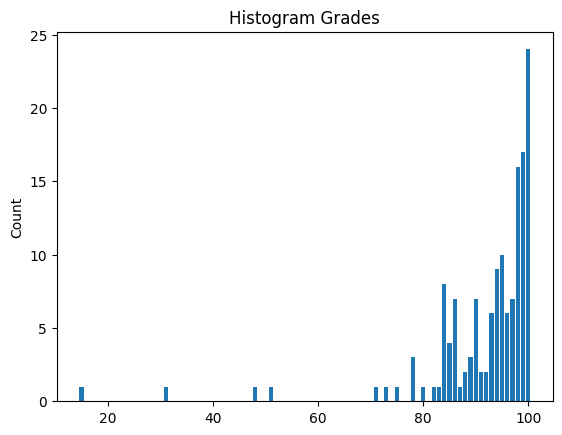

In [126]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

Histogram Plot of Grades:

- The peak is very close to 100, indicating that most of the students get a very high grade. Also, there seems to be only a few low grades.

- The grades generally varies between 80 to 100.

- This is a left-skewed histogram with a tail on the left, which implies that fewer students receiverd lower grades.

- Outliers are the lowest grades. There is a 15 and a 31 in tha dataset.

- This is an asymmetric histogram. Generally the "normal ditribution" is very common in the nature, but this histogram do not have a bell-shaped curve. It is skewed.

DataFrame now has a new index, and the column previously named "index" is now named "code."

In [127]:
nan_columns = df.columns[df.isna().any()].tolist()
print("Columns with NaN values:", nan_columns)

Columns with NaN values: []


This piece of code checks for columns in the DataFrame (df) that contain NaN (Not a Number) values and prints those columns. NaN values often indicate missing or undefined data in a DataFrame.

Merging scores with features

In [128]:
df = pd.merge(df, scores, on='code', how="left")
df.dropna(inplace=True)
df.drop_duplicates("code",inplace=True, keep="first")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,total_prompts,...,prompt_to_error_ratio,thank_you_frequency,average_response_entropy,response_length,response_sentiment_score,repeating_prompt_frequency,whichQuestStartAskGPT,primitive_grade,ner_count,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,7.0,4.0,0.0,0.0,0.0,280.357143,1575.500000,25.0,...,1.750000,0.0,0.000000,6,0.0,1,2,57.287023,1,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,3.0,0.0,0.0,3.0,170.055556,1173.222222,21.0,...,18.000000,0.0,0.157895,18,0.0,1,1,100.000000,1,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,8.0,3.0,1.0,0.0,7.0,446.777778,1203.888889,21.0,...,1.000000,0.1,0.700000,17,0.0,1,2,57.329215,1,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,2.0,0.0,0.0,0.0,4.0,71.550000,1235.700000,22.0,...,6.666667,0.0,0.190476,6,0.0,1,4,49.185812,1,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,15.0,36.0,0.0,0.0,45.0,128.523256,1023.395349,137.0,...,5.375000,0.0,0.517241,18,0.0,1,1,100.000000,1,100.0


In [129]:
df.columns

Index(['code', '#user_prompts', '#error', '#no', '#thank', '#next', '#entropy',
       'prompt_avg_chars', 'response_avg_chars', 'total_prompts',
       'error_ratio', 'avg_entropy_per_prompt', 'total_chars_per_interaction',
       'prompt_response_char_ratio', 'pos_to_neg_ratio', 'response_complexity',
       'prompt_to_error_ratio', 'thank_you_frequency',
       'average_response_entropy', 'response_length',
       'response_sentiment_score', 'repeating_prompt_frequency',
       'whichQuestStartAskGPT', 'primitive_grade', 'ner_count', 'grade'],
      dtype='object')

In [130]:
from sklearn.preprocessing import MinMaxScaler
#Scaling all the numeric columns -> (sample - mean) / std
num_cols = ['#user_prompts', '#error', '#no', '#thank', '#next', '#entropy',
       'prompt_avg_chars', 'response_avg_chars', 'total_prompts',
       'error_ratio', 'avg_entropy_per_prompt', 'total_chars_per_interaction',
       'prompt_response_char_ratio', 'pos_to_neg_ratio', 'response_complexity',
       'prompt_to_error_ratio', 'thank_you_frequency',
       'average_response_entropy', 'response_length',
       'response_sentiment_score', 'repeating_prompt_frequency',
       'whichQuestStartAskGPT', 'primitive_grade', 'ner_count']
scaler = MinMaxScaler()
scaled_df = df.copy()
scaled_df[num_cols] = scaler.fit_transform(scaled_df[num_cols])
print('The data has been scaled successfully!')

scaled_df

The data has been scaled successfully!


,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,total_prompts,...,prompt_to_error_ratio,thank_you_frequency,average_response_entropy,response_length,response_sentiment_score,repeating_prompt_frequency,whichQuestStartAskGPT,primitive_grade,ner_count,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.131313,0.051095,0.031746,0.0,0.000000,0.000000,0.264625,0.724517,0.090909,...,0.015634,0.000000,0.000000,0.076923,0.0,1.0,0.333333,0.572870,0.0,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.171717,0.000000,0.023810,0.0,0.000000,0.037975,0.154363,0.508703,0.075758,...,0.220055,0.000000,0.131912,1.000000,0.0,1.0,0.222222,1.000000,0.0,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,0.080808,0.058394,0.023810,0.2,0.000000,0.088608,0.430985,0.525155,0.075758,...,0.006199,0.466667,0.584810,0.923077,0.0,1.0,0.333333,0.573292,0.0,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.191919,0.014599,0.000000,0.0,0.000000,0.050633,0.055893,0.542221,0.079545,...,0.077484,0.000000,0.159132,0.076923,0.0,1.0,0.555556,0.491858,0.0,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.858586,0.109489,0.285714,0.0,0.000000,0.569620,0.112846,0.428324,0.515152,...,0.061235,0.000000,0.432126,1.000000,0.0,1.0,0.222222,1.000000,0.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.202020,0.007299,0.071429,0.0,0.000000,0.050633,0.113656,0.546086,0.113636,...,0.125706,0.000000,0.151899,0.923077,0.0,1.0,0.777778,1.000000,0.0,93.0
136,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.707071,0.029197,0.134921,0.2,0.166667,0.177215,0.154195,0.559466,0.352273,...,0.172252,0.064815,0.162447,1.000000,0.0,1.0,0.444444,0.896941,0.0,100.0
137,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.292929,0.094891,0.063492,0.0,0.666667,0.037975,0.479589,0.444367,0.204545,...,0.020576,0.000000,0.080849,0.076923,0.0,1.0,0.222222,1.000000,0.0,98.0
138,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.131313,0.000000,0.103175,0.0,0.166667,0.037975,0.255271,0.737086,0.102273,...,0.169736,0.000000,0.167089,1.000000,0.0,1.0,0.222222,1.000000,0.0,100.0


A brief explanalation for this piece of code:

1) A left merge is performed between df and scores DataFrames based on the "code" column.

2) Drop rows with NaN values from the merged DataFrame.

3) Drop duplicate rows based on the "code" column, keeping only the first occurrence of each code.

In [131]:
selected_features_DecisionTree = ['total_chars_per_interaction', 'repeating_prompt_frequency', 'whichQuestStartAskGPT', 'primitive_grade'] #selected from corr heatmap

# Select relevant data
selected_data = df[selected_features_DecisionTree]

X = selected_data.to_numpy()
y = df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 4) (122,)


In this piece of code, for machine learning, the feature matrix "X" and target array "y" is prepared. Target array is "grade".

# Train/Test Data

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


In this piece of code, the data is splitted into training and test sets, so we can train our model on one portion (80%) of the data and evaluate its performance on another independent portion (20%).

### 3.1 **Decision Tree Regressor**

This model is run for analysis on dataframe.

In [133]:
from sklearn.model_selection import KFold
# Crating an array of different values of max_depth
max_depth_arr = np.arange(1, 50)

# Now we want to evaluate the decision tree model on all these values
# We loop through all max_depth values and conduct a cross validation
# evaluation for each max_depth value

# Arrays to save the average cross-validation scores for each max_depth value
# on the train and validation data of each split
train_score_arr = []
val_score_arr = []
for max_depth in max_depth_arr:

  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save accuracies for each fold split
  fold_train_score_arr = []
  fold_val_score_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    xt = X_train[train_idx]
    yt = y_train[train_idx]

    xv = X_train[val_idx]
    yv = y_train[val_idx]

    model = DecisionTreeRegressor(
        criterion='squared_error',
        random_state=42,
        max_depth=max_depth)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing accuracy

    # Train
    error = mean_squared_error(y_pred_train, yt)
    fold_train_score_arr.append(error)

    # Validation
    error = mean_squared_error(y_pred_val, yv)
    fold_val_score_arr.append(error)

  # After running all splits, we compute the avgof accuracies in
  # the cross-validation run
  train_score_mean = np.mean(fold_train_score_arr)
  val_score_mean = np.mean(fold_val_score_arr)

  # Appending the avg/std scores of this max_depth value
  train_score_arr.append(train_score_mean)
  val_score_arr.append(val_score_mean)

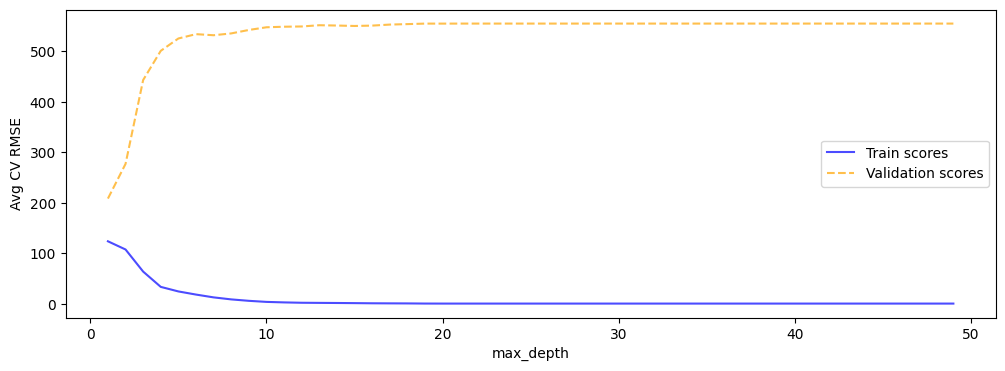

In [134]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(max_depth_arr, train_score_arr, color='blue', alpha=0.7, label='Train scores')
ax.plot(max_depth_arr, val_score_arr, color='orange', alpha=0.7, linestyle='--', label='Validation scores')
plt.legend()
ax.set_xlabel('max_depth')
ax.set_ylabel('Avg CV RMSE')

plt.show()

In [135]:
min_samples_split_arr = np.arange(5, 50)

# Now we want to evaluate the decision tree model on all these values
# We loop through all min_samples_split values and conduct a cross validation
# evaluation for each min_samples_split value

# Arrays to save the average cross-validation scores for each min_samples_split value
# on the train and validation data of each split
train_score_arr = []
val_score_arr = []
for min_samples_split in min_samples_split_arr:

  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save accuracies for each fold split
  fold_train_score_arr = []
  fold_val_score_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    xt = X_train[train_idx]
    yt = y_train[train_idx]

    xv = X_train[val_idx]
    yv = y_train[val_idx]

    model = DecisionTreeRegressor(
        criterion='squared_error',
        random_state=42,
        max_depth=8,
        min_samples_split = min_samples_split)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing accuracy

    # Train
    error = mean_squared_error(y_pred_train, yt, squared=False)
    fold_train_score_arr.append(error)

    # Validation
    error = mean_squared_error(y_pred_val, yv, squared=False)
    fold_val_score_arr.append(error)

  # After running all splits, we compute the avgof accuracies in
  # the cross-validation run
  train_score_mean = np.mean(fold_train_score_arr)
  val_score_mean = np.mean(fold_val_score_arr)

  # Appending the avg/std scores of this max_depth value
  train_score_arr.append(train_score_mean)
  val_score_arr.append(val_score_mean)

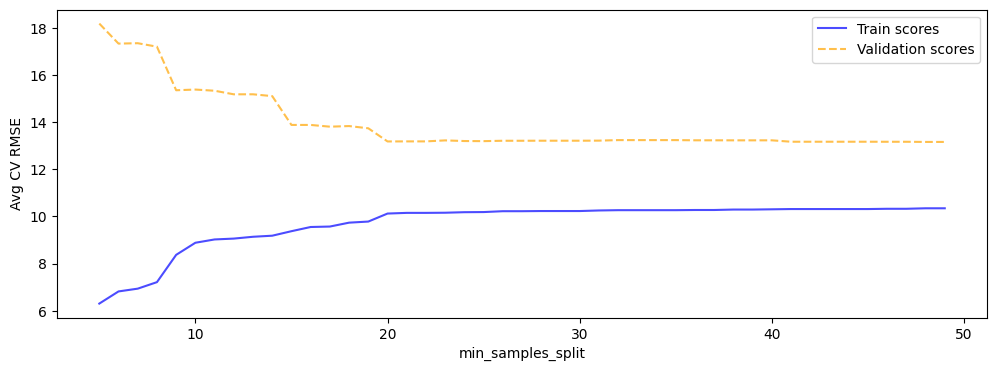

In [136]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(min_samples_split_arr, train_score_arr, color='blue', alpha=0.7, label='Train scores')
ax.plot(min_samples_split_arr, val_score_arr, color='orange', alpha=0.7, linestyle='--', label='Validation scores')
plt.legend()
ax.set_xlabel('min_samples_split')
ax.set_ylabel('Avg CV RMSE')

plt.show()

In [137]:
regressor = DecisionTreeRegressor(random_state=0, criterion='squared_error', max_depth=8, min_samples_split = 20 )
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_split=20, random_state=0)

In [138]:
extracted_MSEs = regressor.tree_.impurity
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 163.42034222552866
Node 1 has MSE 126.39409722222263
Node 2 has MSE 667.3333333333339
Node 3 has MSE 63.20517901968742
Node 4 has MSE 149.0914127423821
Node 5 has MSE 28.042387543253426
Node 6 has MSE 24.88083333333452
Node 7 has MSE 18.626666666667006
Node 8 has MSE 24.515555555553874
Node 9 has MSE 4.195555555555984
Node 10 has MSE 28.48999999999978
Node 11 has MSE 16.535714285713766
Node 12 has MSE 34.75
Node 13 has MSE 42.859375
Node 14 has MSE 0.0


In [139]:
# Plotting the Tree
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=selected_features_DecisionTree)
graph = graphviz.Source(dot_data)
graph.render("hw")

'hw.pdf'

The given pdf has the corresponding decision tree plot.

In [140]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

# Calculation of R-Squared (R2)
print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))

MSE Train: 107.21421143063844
MSE TEST: 97.65679786857494
R2 Train: 0.3439359508703199
R2 TEST: 0.13012714608415277


In [141]:
y_test_pred

array([98.26666667, 84.33333333, 92.5       , 91.875     , 95.5       ,
       92.5       , 95.5       , 92.5       , 95.5       , 84.33333333,
       95.5       , 92.5       , 92.5       , 92.5       , 95.5       ,
       94.13333333, 92.5       , 92.5       , 87.52631579, 87.52631579,
       91.875     , 94.13333333, 87.52631579, 92.5       , 91.875     ])

### 3.2 **Neural Network Model**

Since we have a numerical dataset, we chose using a feedforward neural network (multilayer perceptron). Five features are selected with highest correlation to grade column, extracted from correlation heatmap. This map is shown in data exploration part.

In [142]:
# Define target column and selected features
target_column = 'grade'
selected_features_NN = ['total_chars_per_interaction', 'repeating_prompt_frequency', 'response_avg_chars', 'prompt_avg_chars', '#user_prompts']

# Select relevant data
selected_data = df[selected_features_NN + [target_column]]

# Split the data into training and testing sets
train_data, test_data = train_test_split(selected_data, test_size=0.2, random_state=42)

# Print the shapes of train and test data
print("Train data shape:", train_data[selected_features_NN].shape)
print("Test data shape:", test_data[selected_features_NN].shape)

# Scale the data
scaler = StandardScaler()
train_data[selected_features_NN] = scaler.fit_transform(train_data[selected_features_NN])
test_data[selected_features_NN] = scaler.transform(test_data[selected_features_NN])

# Define the neural network model
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(len(selected_features_NN),)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='linear')
])

# Compile the model using the custom accuracy metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Display the model summary
model.summary()

# Prepare labels for training and testing
train_labels = np.array(train_data[target_column])
test_labels = np.array(test_data[target_column])

# Set up early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data[selected_features_NN], train_labels,
    epochs=22,  # You can adjust the number of epochs
    batch_size=4,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Train data shape: (97, 5)
Test data shape: (25, 5)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               1536      
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 67585 (264.00 KB)
Trainable params: 67585 (264.00 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

Architecture:

Input Layer:

Neurons: Equal to the number of selected features (len(selected_features)), which is 5 in this case.
Hidden Layer 1:

Neurons: 256 neurons.
Activation Function: Rectified Linear Unit (ReLU).
Dropout Layer 1:

Dropout Rate: 0.5.
Hidden Layer 2:

Neurons: 128 neurons.
Activation Function: Rectified Linear Unit (ReLU).
Dropout Layer 2:

Dropout Rate: 0.5.
Output Layer:

Neurons: Single neuron (regression task).
Activation Function: Linear.
Compilation:

Optimizer:

Adam optimizer is used for gradient-based optimization.
Loss Function:

Mean Squared Error (MSE) is chosen as the loss function, suitable for regression tasks.
Metrics:

Mean Absolute Error (MAE) is chosen as an additional metric to monitor during training.
Training:

The model is trained for 22 epochs.

Batch size: 4.

Validation data (20% of training data) is used for monitoring.

Early stopping is applied with a patience of 3 epochs to prevent overfitting.

The model's training progress is stored in the history variable.

Evaluation of NN Model

In [143]:
# Evaluate the model
predictions = model.predict(test_data[selected_features_NN]).flatten()

# Calculate evaluation metrics
mse = mean_squared_error(test_labels, predictions)
mae = mean_absolute_error(test_labels, predictions)
r2 = r2_score(test_labels, predictions)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

1/1 [==============================] - 0s 122ms/step
Mean Squared Error (MSE): 382.5292713973491
Mean Absolute Error (MAE): 16.663961639404295
R-squared (R2): -2.4073596132506228


MSE (Mean Squared Error):

MSE for the test set is 382.52, which is a relatively high value implying that the model's predictions deviate more from the actual values. The model has a poor performance on unseen data.

R2 (R-Squared):

R2 for the test set is -2.4, which is a negative number, implies that the model performs poorly on the unseen data, and the predictions are even worse than the simple mean.

There is a possible overfitting problem with the model. In order to improve the model's performance on the test set, techniques such as cross-validation, or hyperparamater tuning can be applied. Yet, we think that the major problem with our models is that the features are not that correlated or explanatory with the "grade".

### 3.3 **Random Forest Algorithm**

In [144]:
from sklearn.ensemble import RandomForestRegressor

random_forest_model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
random_forest_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, n_estimators=1000, random_state=42)

In [145]:
# Prediction
y_train_pred_rf = random_forest_model.predict(X_train)
y_test_pred_rf = random_forest_model.predict(X_test)

print(y_test_pred_rf)

[98.42839894 80.65398182 96.61056825 96.57213111 93.51673326 94.02173325
 94.59394631 93.74346637 94.85729389 90.507      94.51476967 95.07796993
 90.47495449 93.23136452 94.24228129 94.24109214 92.27987999 95.02980326
 94.41049211 90.6494619  95.52299267 94.10350872 89.65564903 93.4304395
 95.70201831]


Evaluation of The Model

In [146]:
# Calculation of Mean Squared Error (MSE) for the training set
print("MSE Train:", mean_squared_error(y_train,y_train_pred_rf))

# Calculation of Mean Squared Error (MSE) for the test set
print("MSE Test:", mean_squared_error(y_test,y_test_pred_rf))

# Calculation of R-Squared (R2) for the training set
print("R2 Train:", r2_score(y_train,y_train_pred_rf))

# Calculation of R-Squared (R2) for the test set
print("R2 Test:", r2_score(y_test,y_test_pred_rf))

MSE Train: 33.26604468836081
MSE Test: 110.58181479833952
R2 Train: 0.7964387772334248
R2 Test: 0.014998229214117864


### 3.4 **XGBoost (Extreme Gradient Boosting) Model**


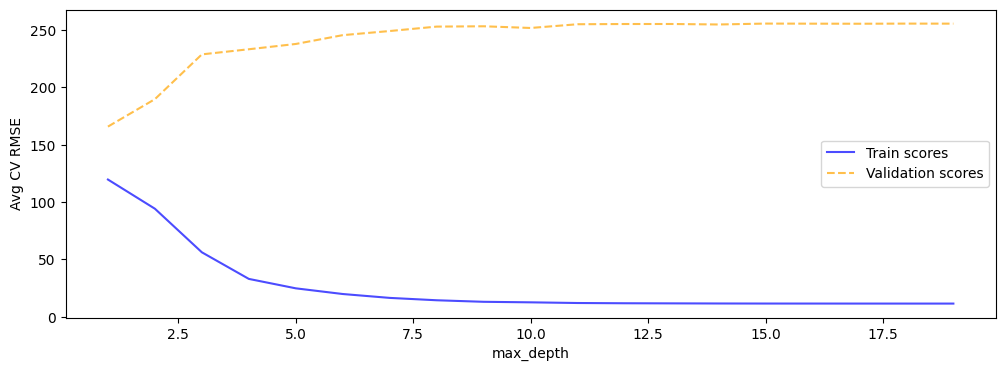

In [147]:
import xgboost as xgb

# Specify max_depth values to explore
max_depth_arr = np.arange(1, 20)

# Arrays to store results for each max_depth
train_score_arr = []
val_score_arr = []
best_max_depth = 0
best_rmse = float('inf')

# Conduct K-Fold cross-validation for each max_depth
for max_depth in max_depth_arr:
    skf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_train_score_arr = []
    fold_val_score_arr = []

    for i, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        xt = X_train[train_idx]
        yt = y_train[train_idx]

        xv = X_train[val_idx]
        yv = y_train[val_idx]

        # Create XGBoost model with specified max_depth
        model = xgb.XGBRegressor(
            objective="reg:squarederror",
            n_estimators=50,  # Set a reasonable default for n_estimators
            learning_rate=0.05,  # Set a reasonable default for learning_rate
            max_depth=max_depth,
            random_state=42
        )

        # Fit the model
        model.fit(xt, yt)

        # Get predictions
        y_pred_train = model.predict(xt)
        y_pred_val = model.predict(xv)

        # Compute RMSE
        error_train = mean_squared_error(y_pred_train, yt)
        error_val = mean_squared_error(y_pred_val, yv)

        fold_train_score_arr.append(error_train)
        fold_val_score_arr.append(error_val)

    # Compute average scores across folds
    train_score_mean = np.mean(fold_train_score_arr)
    val_score_mean = np.mean(fold_val_score_arr)

    # Store scores and update best max_depth if needed
    train_score_arr.append(train_score_mean)
    val_score_arr.append(val_score_mean)
    if val_score_mean < best_rmse:
        best_max_depth = max_depth
        best_rmse = val_score_mean

# Visualize results
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(max_depth_arr, train_score_arr, color='blue', alpha=0.7, label='Train scores')
ax.plot(max_depth_arr, val_score_arr, color='orange', alpha=0.7, linestyle='--', label='Validation scores')
plt.legend()
ax.set_xlabel('max_depth')
ax.set_ylabel('Avg CV RMSE')
plt.show()

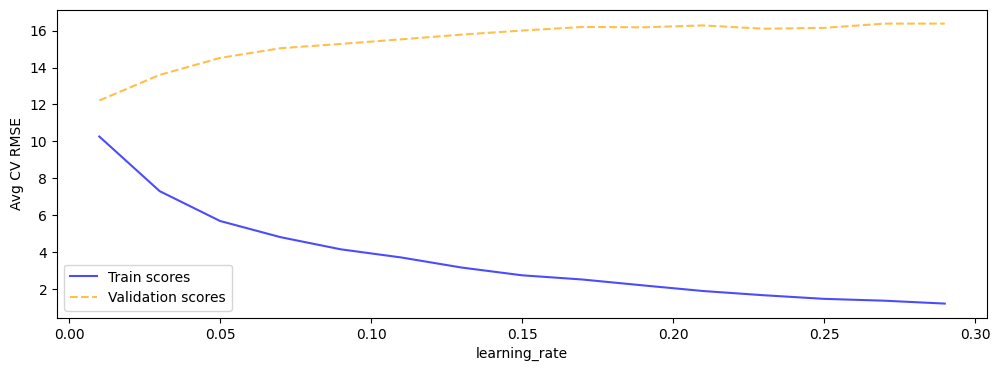

In [148]:
# Specify learning_rate values to explore
learning_rate_arr = np.arange(0.01, 0.3, 0.02)

# Arrays to store results for each learning_rate
train_score_arr = []
val_score_arr = []
best_learning_rate = 0
best_rmse = float('inf')

# Conduct K-Fold cross-validation for each learning_rate
for learning_rate in learning_rate_arr:
    skf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_train_score_arr = []
    fold_val_score_arr = []

    for i, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        xt = X_train[train_idx]  # Assuming X_train is a DataFrame
        yt = y_train[train_idx]

        xv = X_train[val_idx]
        yv = y_train[val_idx]

        # Create XGBoost model with specified learning_rate
        model = xgb.XGBRegressor(
            objective="reg:squarederror",
            n_estimators=50,  # Set a reasonable default for n_estimators
            max_depth=4,  # Set a reasonable default for max_depth
            learning_rate=learning_rate,
            random_state=42
        )

        # Fit the model
        model.fit(xt, yt)

        # Get predictions
        y_pred_train = model.predict(xt)
        y_pred_val = model.predict(xv)

        # Compute RMSE
        error_train = mean_squared_error(y_pred_train, yt, squared=False)
        error_val = mean_squared_error(y_pred_val, yv, squared=False)

        fold_train_score_arr.append(error_train)
        fold_val_score_arr.append(error_val)

    # Compute average scores across folds
    train_score_mean = np.mean(fold_train_score_arr)
    val_score_mean = np.mean(fold_val_score_arr)

    # Store scores and update best learning_rate if needed
    train_score_arr.append(train_score_mean)
    val_score_arr.append(val_score_mean)
    if val_score_mean < best_rmse:
        best_learning_rate = learning_rate
        best_rmse = val_score_mean

# Visualize results
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(learning_rate_arr, train_score_arr, color='blue', alpha=0.7, label='Train scores')
ax.plot(learning_rate_arr, val_score_arr, color='orange', alpha=0.7, linestyle='--', label='Validation scores')
plt.legend()
ax.set_xlabel('learning_rate')
ax.set_ylabel('Avg CV RMSE')
plt.show()

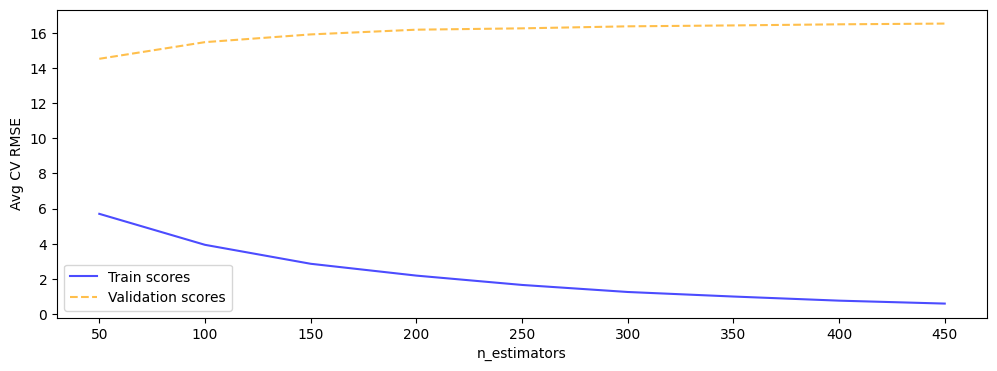

In [149]:
# Specify n_estimators values to explore
n_estimators_arr = np.arange(50, 500, 50)

# Arrays to store results for each n_estimators
train_score_arr = []
val_score_arr = []
best_n_estimators = 0
best_rmse = float('inf')

# Conduct K-Fold cross-validation for each n_estimators
for n_estimators in n_estimators_arr:
    skf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_train_score_arr = []
    fold_val_score_arr = []

    for i, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        xt = X_train[train_idx]  # Assuming X_train is a DataFrame
        yt = y_train[train_idx]

        xv = X_train[val_idx]
        yv = y_train[val_idx]

        # Create XGBoost model with specified n_estimators
        model = xgb.XGBRegressor(
            objective="reg:squarederror",
            n_estimators=n_estimators,
            max_depth=4,  # Set a reasonable default for max_depth
            learning_rate=0.05,  # Set a reasonable default for learning_rate
            random_state=42
        )

        # Fit the model
        model.fit(xt, yt)

        # Get predictions
        y_pred_train = model.predict(xt)
        y_pred_val = model.predict(xv)

        # Compute RMSE
        error_train = mean_squared_error(y_pred_train, yt, squared=False)
        error_val = mean_squared_error(y_pred_val, yv, squared=False)

        fold_train_score_arr.append(error_train)
        fold_val_score_arr.append(error_val)

    # Compute average scores across folds
    train_score_mean = np.mean(fold_train_score_arr)
    val_score_mean = np.mean(fold_val_score_arr)

    # Store scores and update best n_estimators if needed
    train_score_arr.append(train_score_mean)
    val_score_arr.append(val_score_mean)
    if val_score_mean < best_rmse:
        best_n_estimators = n_estimators
        best_rmse = val_score_mean

# Visualize results
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(n_estimators_arr, train_score_arr, color='blue', alpha=0.7, label='Train scores')
ax.plot(n_estimators_arr, val_score_arr, color='orange', alpha=0.7, linestyle='--', label='Validation scores')
plt.legend()
ax.set_xlabel('n_estimators')
ax.set_ylabel('Avg CV RMSE')
plt.show()

In [150]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective = "reg:squarederror", n_estimators = 50, learning_rate = 0.05, max_depth = 4)

xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [151]:
# Prediction
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

print(y_test_pred_xgb)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred_xgb))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred_xgb))

print("R2 Train:", r2_score(y_train,y_train_pred_xgb))
print("R2 TEST:", r2_score(y_test,y_test_pred_xgb))


[95.05329 84.477   94.57996 95.22895 94.98687 94.33264 94.98687 94.57996
 94.13253 93.49764 94.13253 94.57996 94.10935 93.46656 94.34103 94.00223
 94.01303 94.57996 91.76483 88.92952 92.20128 93.9342  89.04561 94.25224
 92.20128]
MSE Train: 45.07382760679883
MSE TEST: 99.416104565477
R2 Train: 0.7241847190321353
R2 TEST: 0.11445621307437892


## **Distribution of the Data Sets (Individually for the overall model and different training models):**

In [152]:
# Overview of the dataset
print("Number of instances:", len(df))
print("Number of features:", len(df.columns) - 2)  # Exclude 'code' and 'grade'
print("Descriptive Statistics:")
print(df.describe())

Number of instances: 122
Number of features: 24
Descriptive Statistics:
       #user_prompts      #error         #no      #thank       #next  \
count     122.000000  122.000000  122.000000  122.000000  122.000000   
mean       28.827869    9.622951   10.778689    0.286885    0.245902   
std        20.960684   18.401549   17.374586    0.837938    0.947476   
min         1.000000    0.000000    0.000000    0.000000    0.000000   
25%        14.000000    0.000000    1.000000    0.000000    0.000000   
50%        21.000000    2.500000    5.000000    0.000000    0.000000   
75%        39.250000   13.000000   13.000000    0.000000    0.000000   
max       100.000000  137.000000  126.000000    5.000000    6.000000   

         #entropy  prompt_avg_chars  response_avg_chars  total_prompts  \
count  122.000000        122.000000          122.000000     122.000000   
mean     6.106557        213.618661         1162.226182      49.762295   
std     10.736365        153.256535          254.811151  

## Descriptive Data Analysis


In [153]:
# Overview of the Decision Tree Dataset
df_DT = df[selected_features_DecisionTree + [target_column]]
print("Number of instances:", len(df_DT ))
print("Number of features:", len(df_DT .columns)-1)  # Exclude 'code' and 'grade'
print("Descriptive Statistics:")
print(df_DT .describe())

Number of instances: 122
Number of features: 4
Descriptive Statistics:
       total_chars_per_interaction  repeating_prompt_frequency  \
count                   122.000000                  122.000000   
mean                   1375.844843                    0.983607   
std                     305.404446                    0.127507   
min                     294.000000                    0.000000   
25%                    1211.319872                    1.000000   
50%                    1347.630000                    1.000000   
75%                    1504.073077                    1.000000   
max                    3105.000000                    1.000000   

       whichQuestStartAskGPT  primitive_grade       grade  
count             122.000000       122.000000  122.000000  
mean                2.147541        77.846582   91.754098  
std                 1.807570        28.035498   12.419201  
min                -1.000000         0.000000   15.000000  
25%                 1.000000      

In [154]:
# Overview of the Neural Network Dataset
df_NN = df[selected_features_NN + [target_column]]
print("Number of instances:", len(df_NN))
print("Number of features:", len(df_NN.columns) - 1)  # Exclude 'code' and 'grade'
print("Descriptive Statistics:")
print(df_NN.describe())

Number of instances: 122
Number of features: 5
Descriptive Statistics:
       total_chars_per_interaction  repeating_prompt_frequency  \
count                   122.000000                  122.000000   
mean                   1375.844843                    0.983607   
std                     305.404446                    0.127507   
min                     294.000000                    0.000000   
25%                    1211.319872                    1.000000   
50%                    1347.630000                    1.000000   
75%                    1504.073077                    1.000000   
max                    3105.000000                    1.000000   

       response_avg_chars  prompt_avg_chars  #user_prompts       grade  
count          122.000000        122.000000     122.000000  122.000000  
mean          1162.226182        213.618661      28.827869   91.754098  
std            254.811151        153.256535      20.960684   12.419201  
min            225.000000         15.63636

# Data Exploration

This part of the project is a general overview of the dataset with some statistics such as the number of instances, features, basic descriptive statistics, and some visualizations.

## **Distribution of Grades:**

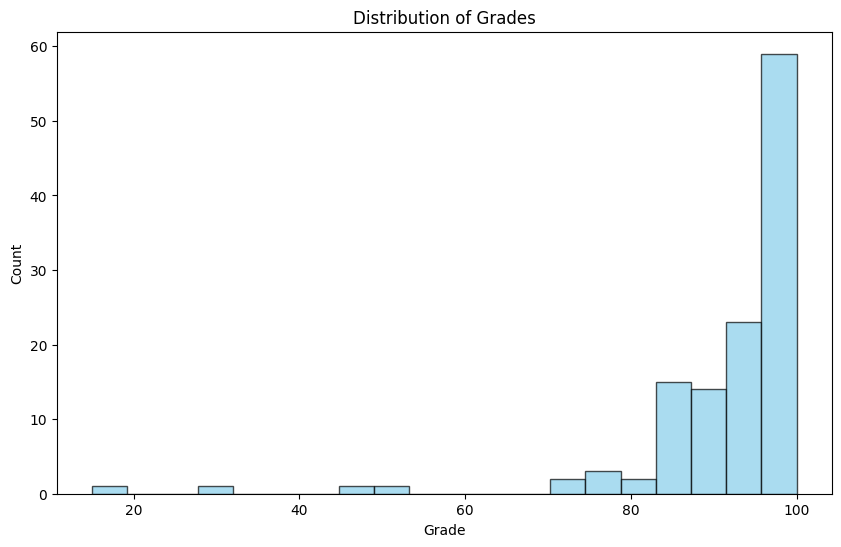

In [155]:
plt.figure(figsize=(10, 6))
plt.title('Distribution of Grades')
plt.hist(df["grade"], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()

## **User prompts distribution:**

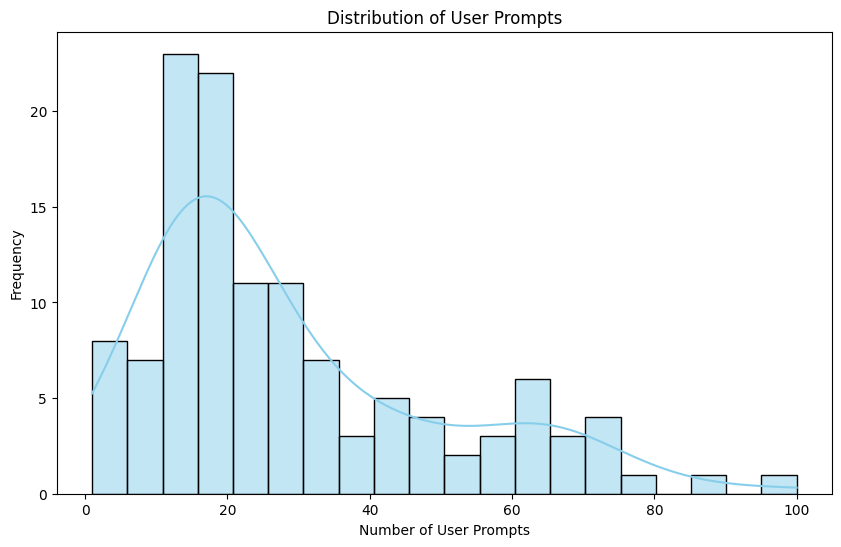

In [156]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="#user_prompts", bins=20, kde=True, color='skyblue')
plt.title("Distribution of User Prompts")
plt.xlabel("Number of User Prompts")
plt.ylabel("Frequency")
plt.show()


## **Plotting Correlation Heatmap (Individually for the overall model and different training models):**

<ipython-input-157-72d9aedf1f6b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


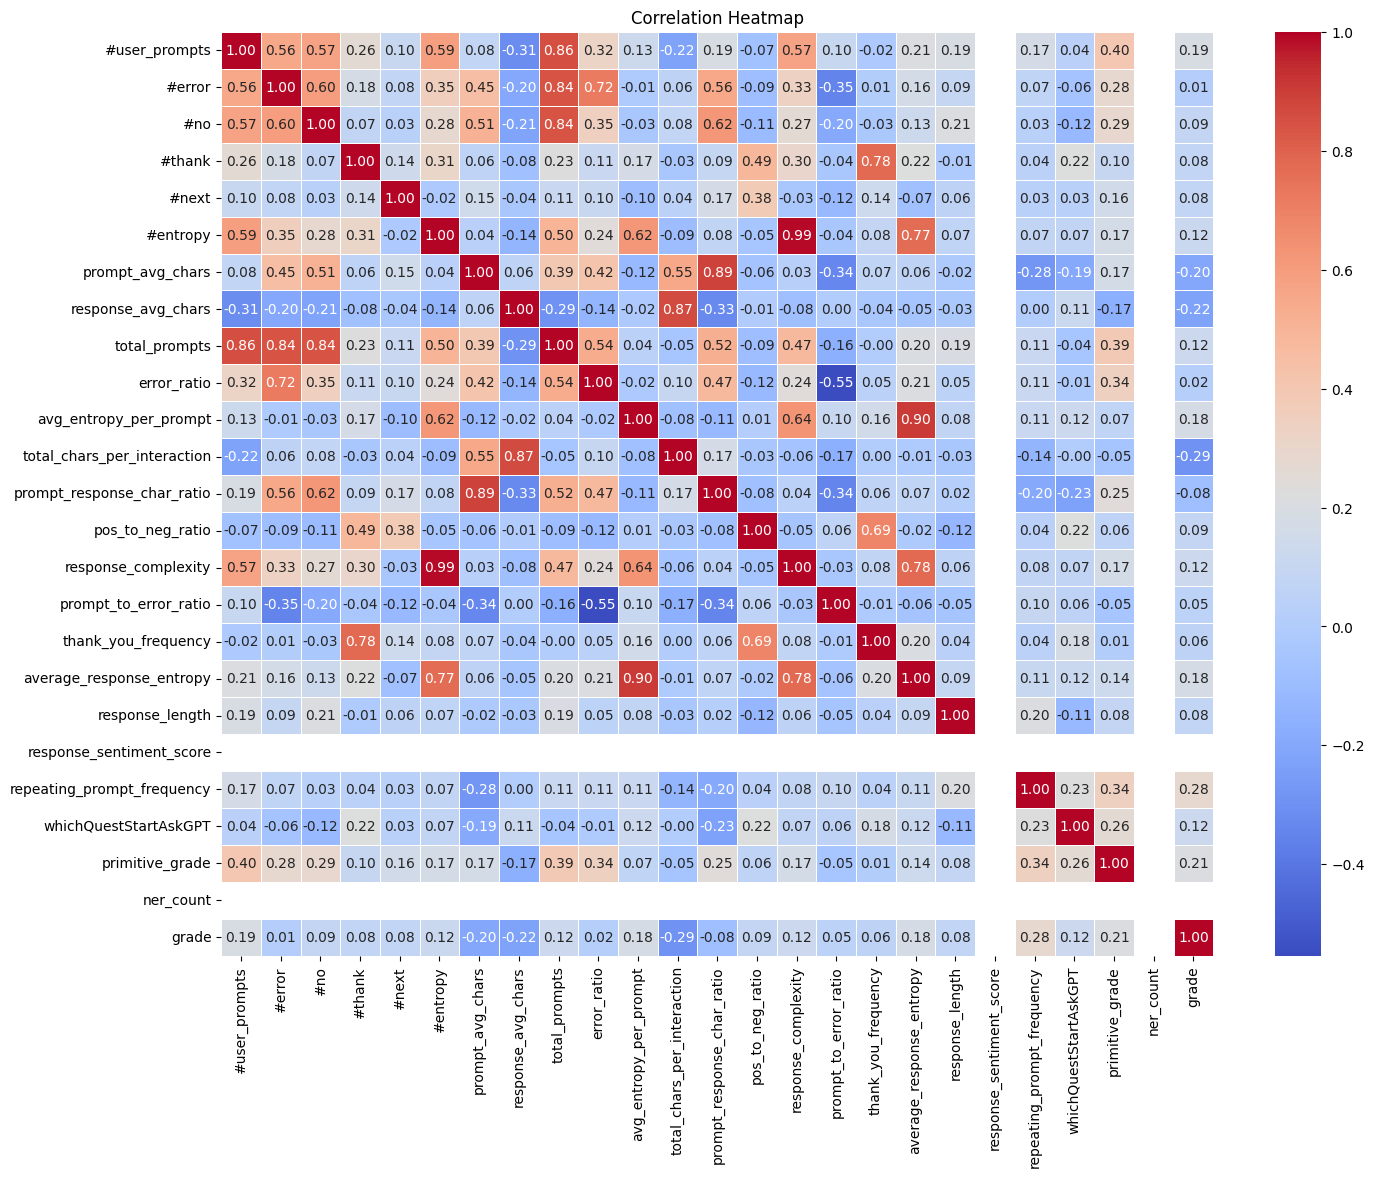

In [157]:
plt.figure(figsize=(16, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

**Select Neural Network Features According to Top 5 Features w/ Most Correlation**

In [158]:
# Select the top 5 features with highest correlation:
top_features = correlation_matrix['grade'].abs().sort_values(ascending=False).head(6).index[1:]
print("Top 5 features with highest correlation:")
print(top_features)

Top 5 features with highest correlation:
Index(['total_chars_per_interaction', 'repeating_prompt_frequency',
       'response_avg_chars', 'primitive_grade', 'prompt_avg_chars'],
      dtype='object')


### **Correlation Heatmap For Decision Tree:**

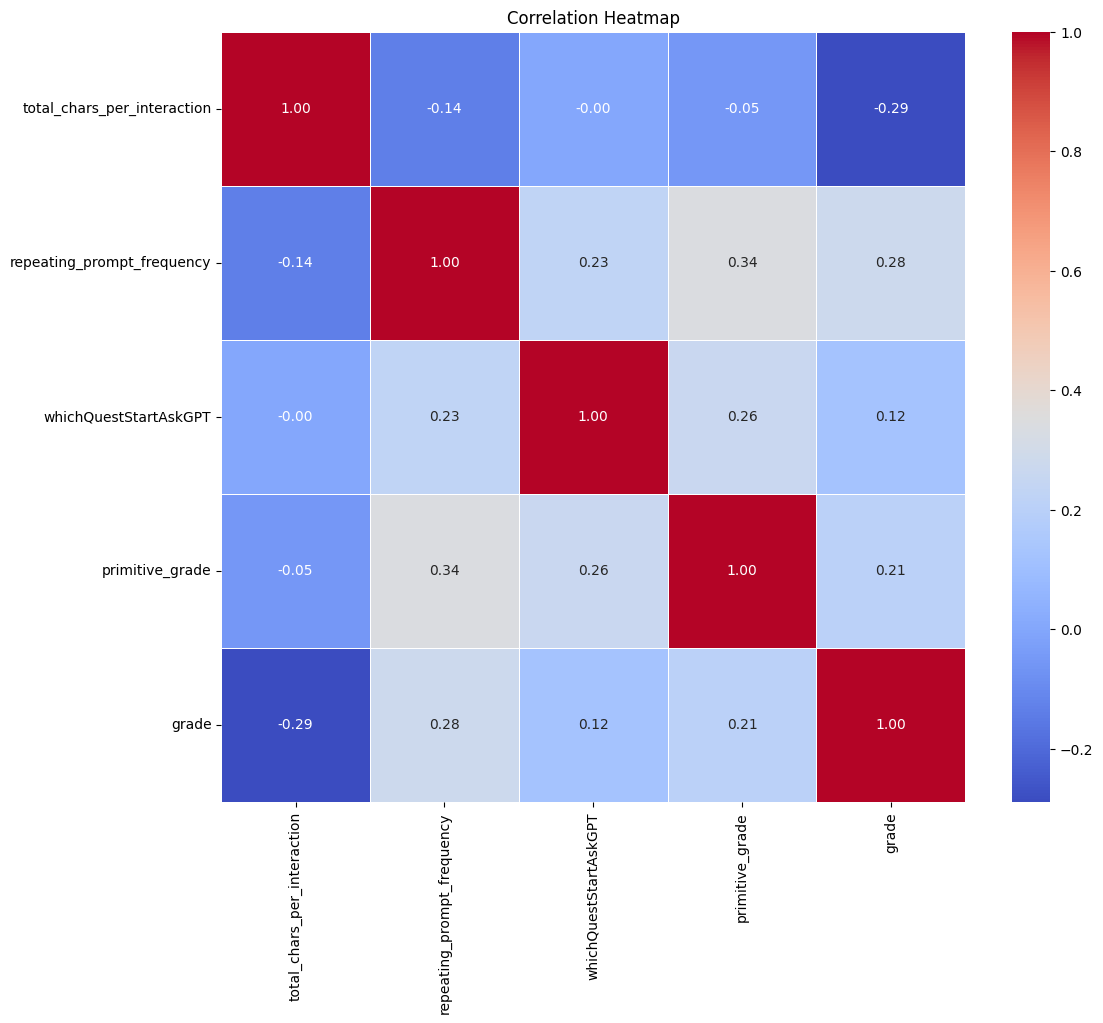

In [159]:
plt.figure(figsize=(12, 10))
correlation_matrix = df_DT.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

### **Correlation Heatmap For Neural Network:**

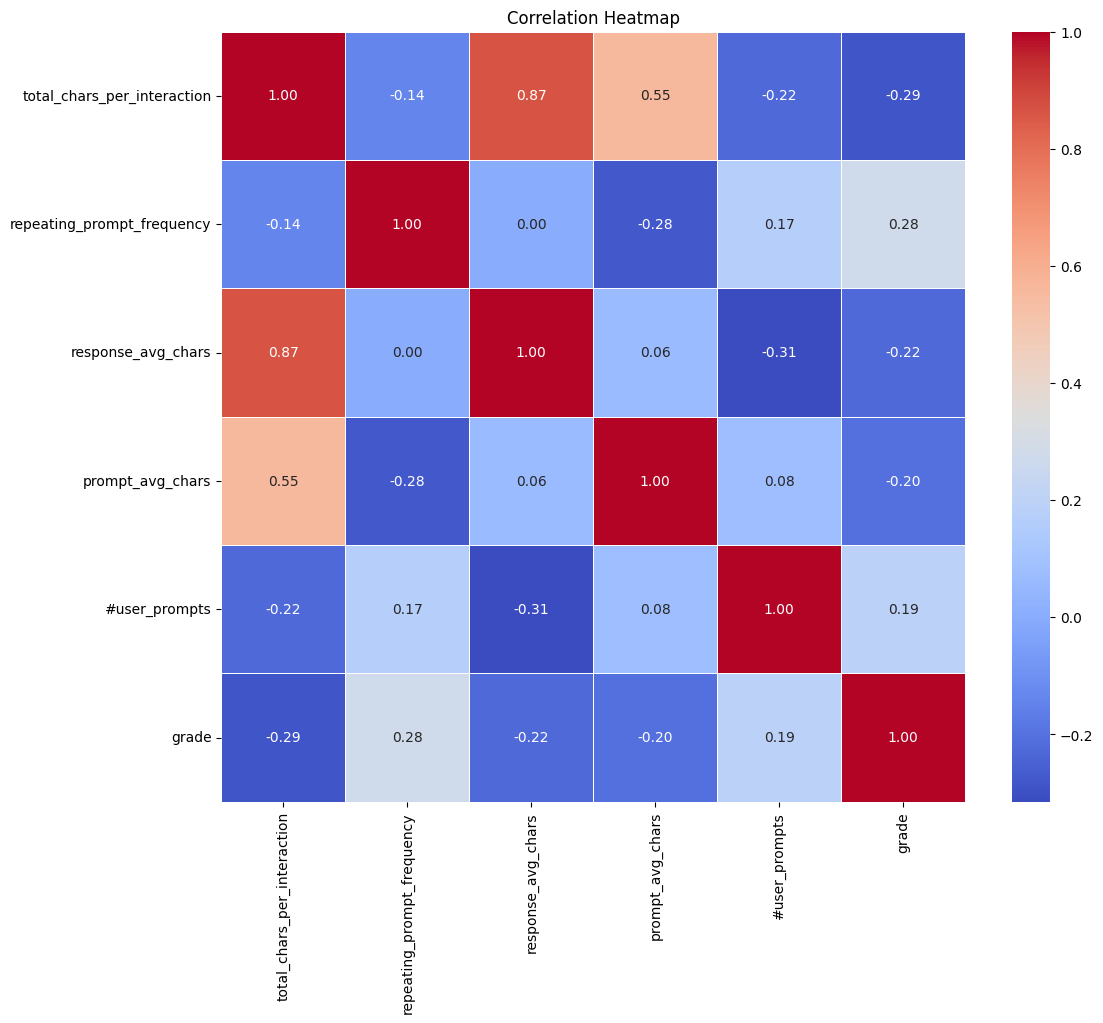

In [160]:
plt.figure(figsize=(12, 10))
correlation_matrix = df_NN.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

Pairplot for a subset of features:

In [161]:
"""# Pairplot for a subset of features
subset_features = ["#user_prompts", "#error", "#thank", "prompt_avg_chars", "response_avg_chars", "grade"]
df_subset = df[subset_features].reset_index(drop=True)  # Reset index and drop it

# Create a scatterplot matrix
sns.pairplot(df_subset, hue="grade", palette="viridis", plot_kws={'alpha':0.5})
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()"""

'# Pairplot for a subset of features\nsubset_features = ["#user_prompts", "#error", "#thank", "prompt_avg_chars", "response_avg_chars", "grade"]\ndf_subset = df[subset_features].reset_index(drop=True)  # Reset index and drop it\n\n# Create a scatterplot matrix\nsns.pairplot(df_subset, hue="grade", palette="viridis", plot_kws={\'alpha\':0.5})\nplt.suptitle("Pairplot of Selected Features", y=1.02)\nplt.show()'

## **Scatter Plots for Decisicion Tree Features vs. Grades**

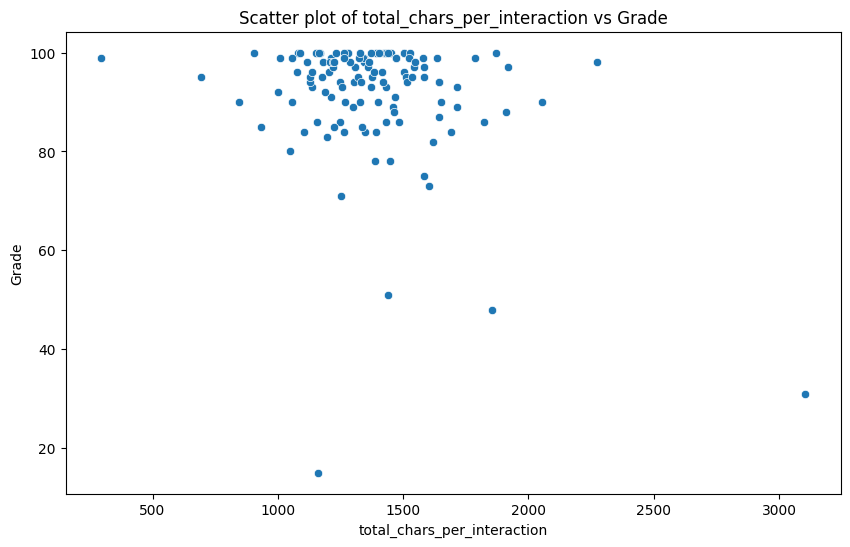

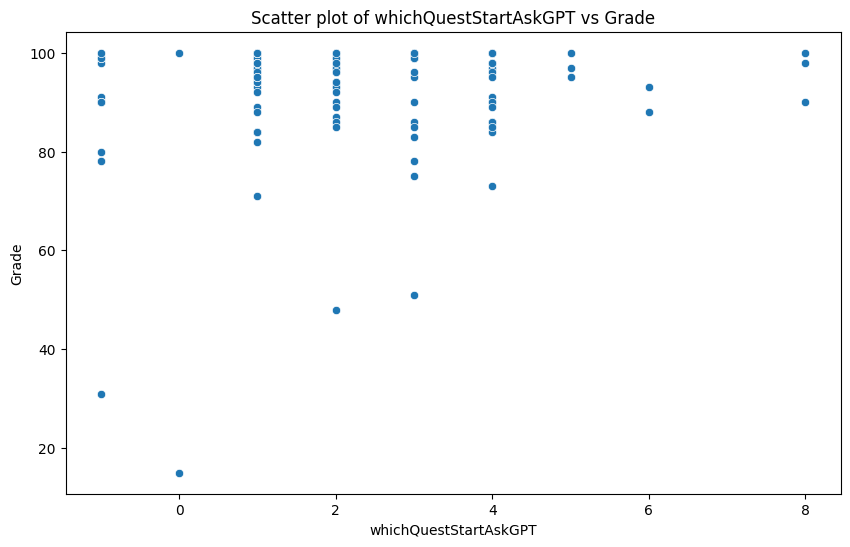

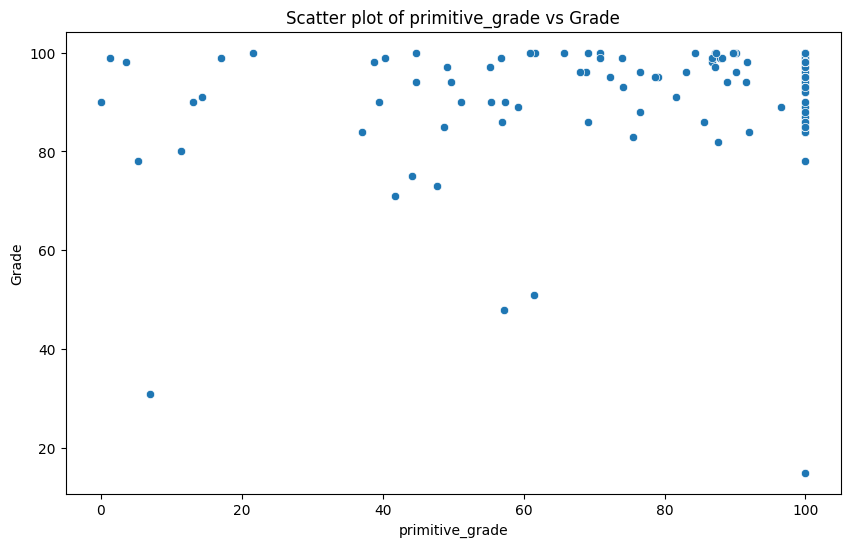

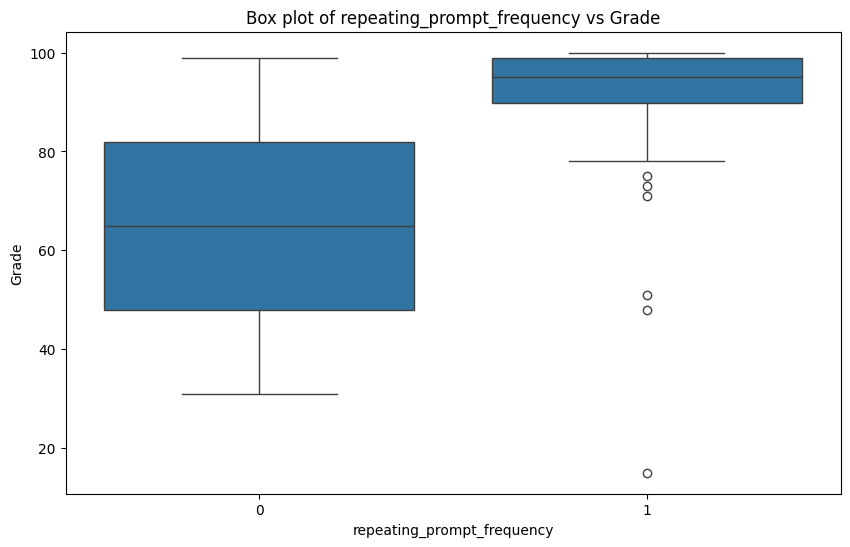

In [162]:
# 'repeating_prompt_frequency' is a categorical feature
categorical_feature = 'repeating_prompt_frequency'

# Scatter plots for continuous features
continuous_features_DT = ['total_chars_per_interaction', 'whichQuestStartAskGPT', 'primitive_grade']

for feature in continuous_features_DT:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_DT, x=feature, y='grade')
    plt.title(f'Scatter plot of {feature} vs Grade')
    plt.xlabel(feature)
    plt.ylabel('Grade')
    plt.show()

# Box plot for the categorical feature
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_DT, x=categorical_feature, y='grade')
plt.title(f'Box plot of {categorical_feature} vs Grade')
plt.xlabel(categorical_feature)
plt.ylabel('Grade')
plt.show()


## **Scatter Plots for Neural Network Features vs. Grades**

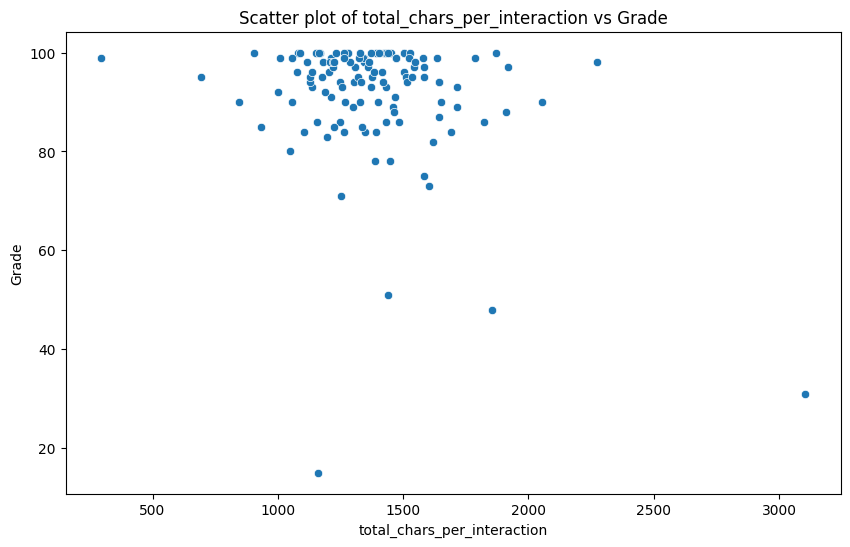

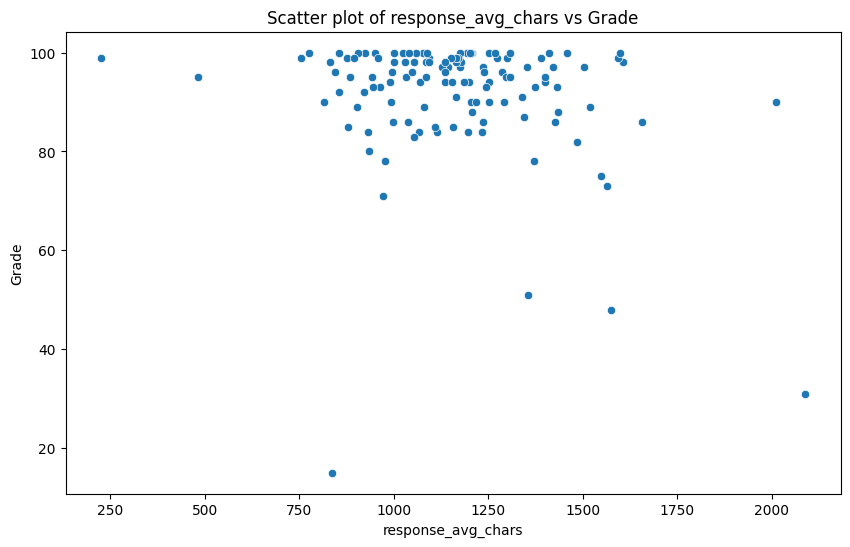

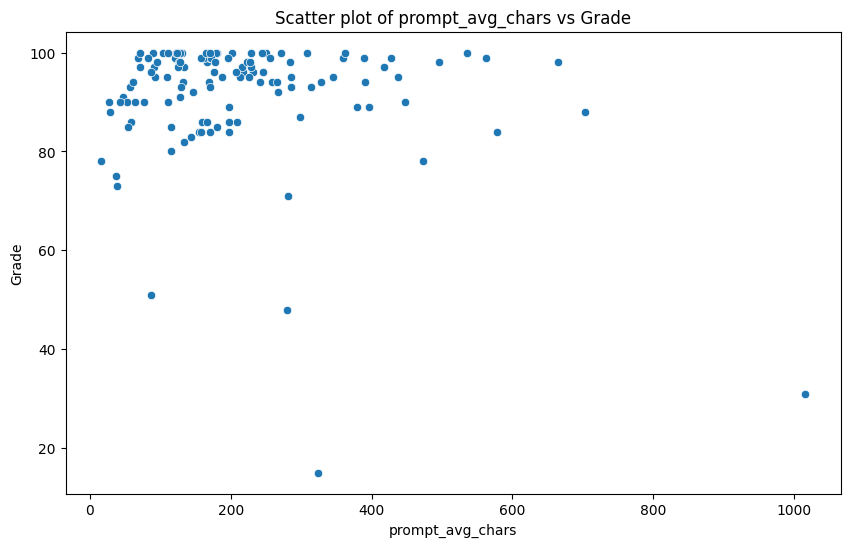

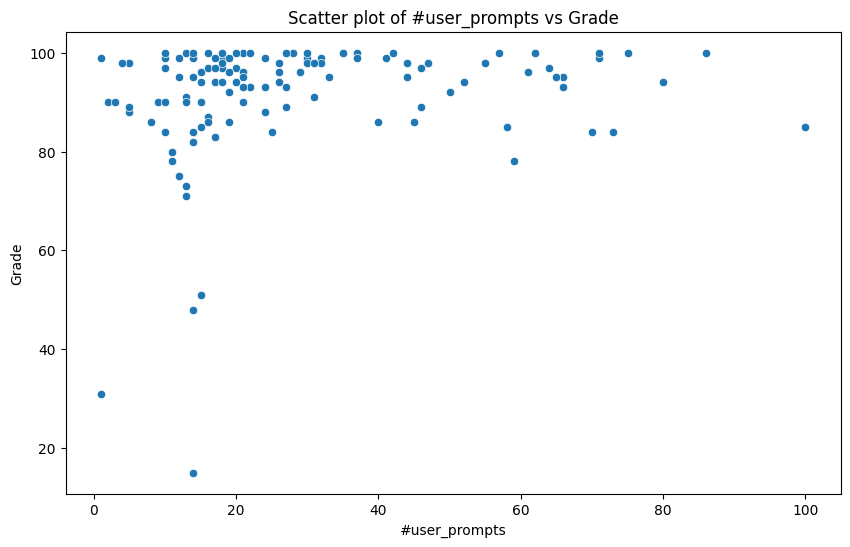

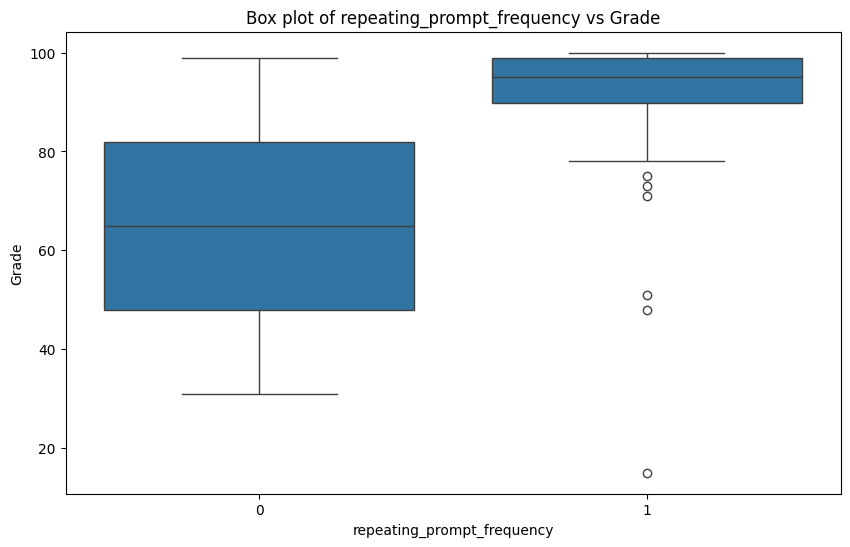

In [163]:
# Scatter plots for continuous features
continuous_features_NN = ['total_chars_per_interaction', 'response_avg_chars', 'prompt_avg_chars', '#user_prompts']

for feature in continuous_features_NN:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_NN, x=feature, y='grade')
    plt.title(f'Scatter plot of {feature} vs Grade')
    plt.xlabel(feature)
    plt.ylabel('Grade')
    plt.show()

# Box plot for the categorical feature
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_NN, x=categorical_feature, y='grade')
plt.title(f'Box plot of {categorical_feature} vs Grade')
plt.xlabel(categorical_feature)
plt.ylabel('Grade')
plt.show()


## **Total Prompts vs. Grades**

In [164]:
# Calculate total_prompts as the sum of #user_prompts and other prompt-related columns
df['total_prompts'] = df['#user_prompts'] + df['#error'] + df['#no'] + df['#thank'] + df['#next'] + df['#entropy']

# Now, let's check the first few rows of the updated DataFrame
# print(df.head())

<ipython-input-165-e2fdd83ededb>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_features = df.groupby('grade').mean().reset_index()
<ipython-input-165-e2fdd83ededb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='grade', y='total_prompts', data=average_features, palette='rocket')


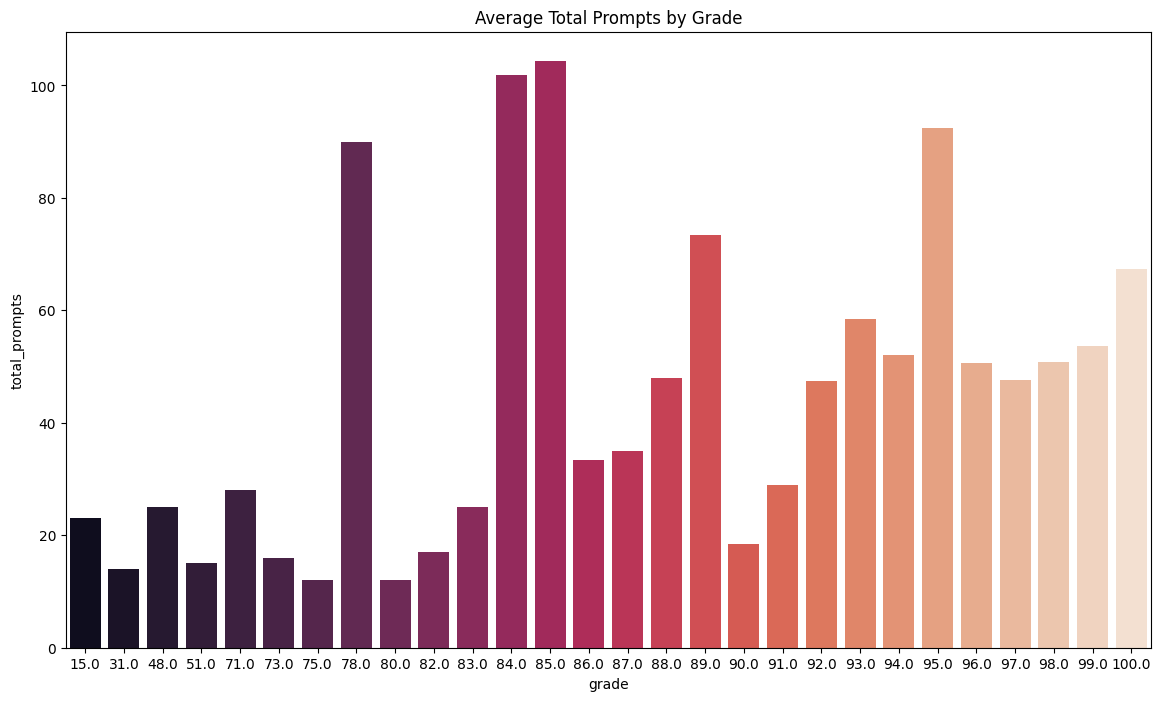

In [165]:
# Bar Plot
average_features = df.groupby('grade').mean().reset_index()
plt.figure(figsize=(14, 8))
sns.barplot(x='grade', y='total_prompts', data=average_features, palette='rocket')
plt.title('Average Total Prompts by Grade')
plt.show()

## **Average Characters in Response vs. Grades**

<ipython-input-166-bf2aeb63ea66>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x='grade', y='response_avg_chars', data=df, palette='Set2')


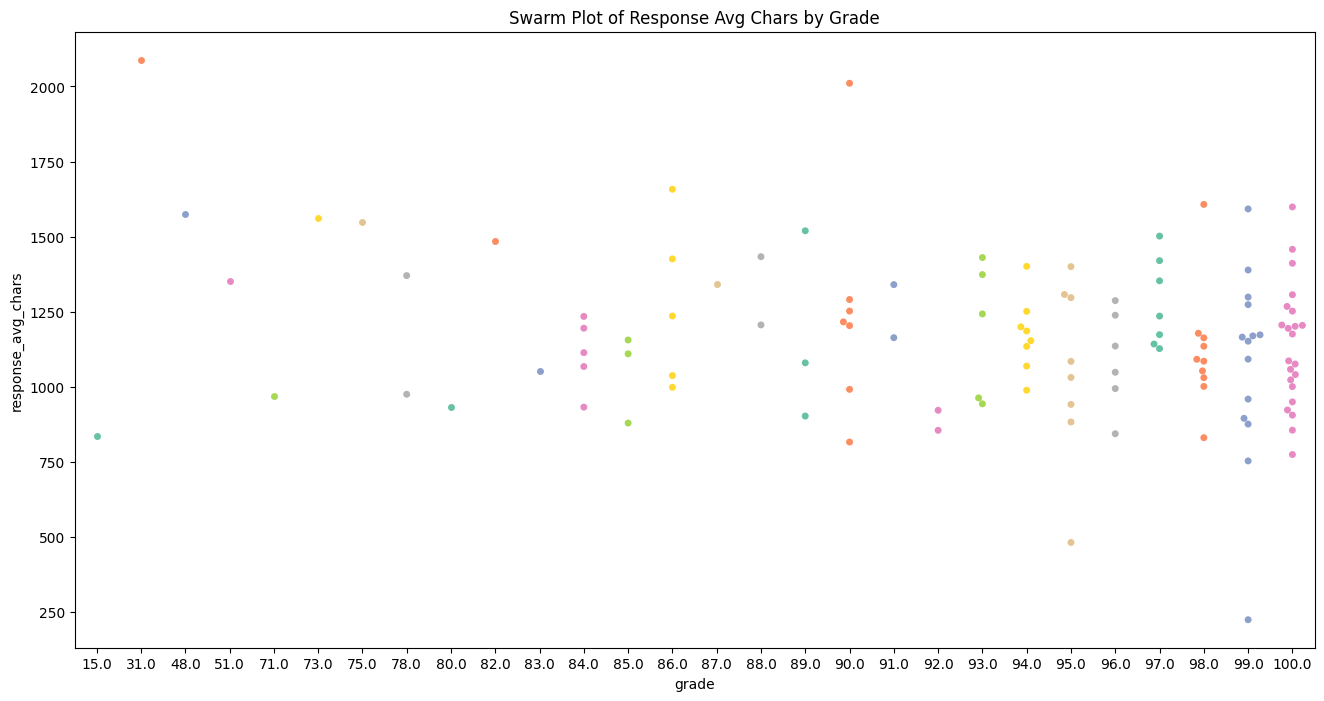

In [166]:
# Swarm Plot
plt.figure(figsize=(16, 8))
sns.swarmplot(x='grade', y='response_avg_chars', data=df, palette='Set2')
plt.title('Swarm Plot of Response Avg Chars by Grade')
plt.show()

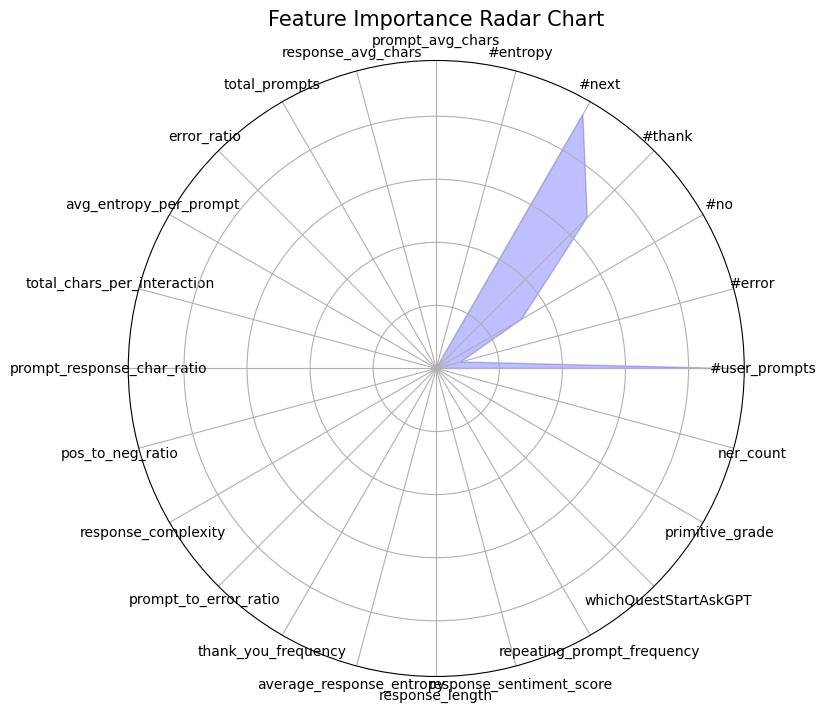

In [167]:
from sklearn.ensemble import RandomForestRegressor

# Assuming you've already defined X and y
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = rf.feature_importances_

# Plot radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Ensure the number of features match the number of ticks and labels
num_features = len(df.columns[1:-1])
angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False)
feature_importances = np.concatenate((feature_importances, [feature_importances[0]]))
angles = np.concatenate((angles, [angles[0]]))

# Pad feature_importances to match the length of angles
while len(feature_importances) < len(angles):
    feature_importances = np.concatenate((feature_importances, [0]))

ax.fill(angles, feature_importances, color='b', alpha=0.25)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(df.columns[1:-1], ha='center', fontsize=10)

plt.title('Feature Importance Radar Chart', size=15)
plt.show()

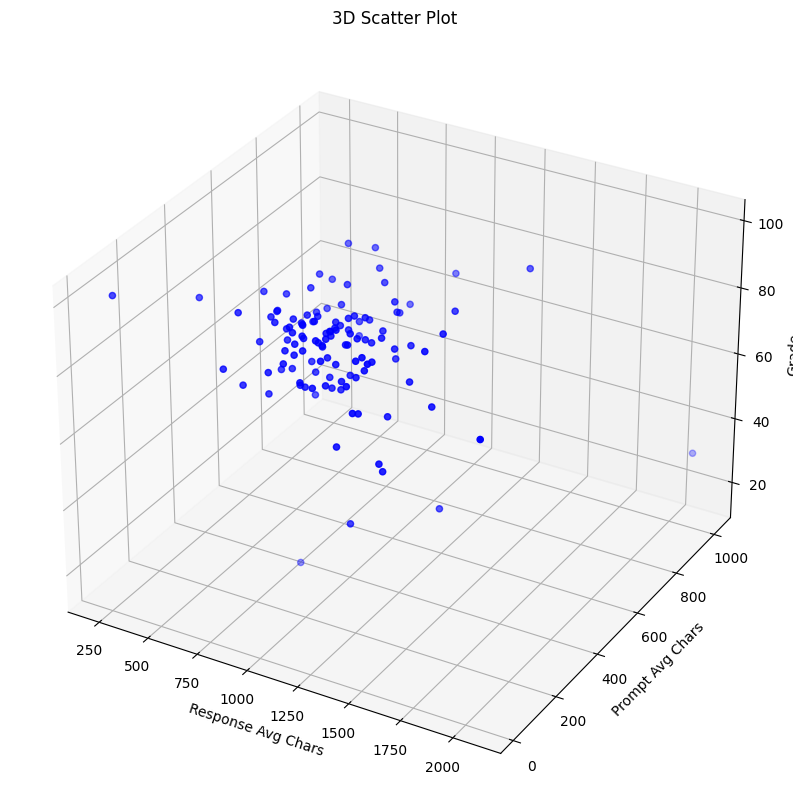

In [168]:
from mpl_toolkits.mplot3d import Axes3D

# 3D Scatter plot using response_avg_chars, prompt_avg_chars, and grade
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['response_avg_chars'], df['prompt_avg_chars'], df['grade'], c='blue', marker='o')

ax.set_xlabel('Response Avg Chars')
ax.set_ylabel('Prompt Avg Chars')
ax.set_zlabel('Grade')

plt.title('3D Scatter Plot')
plt.show()